In [9]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

In [10]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

breast_cancer = load_breast_cancer()

In [11]:
breast_cancerX = breast_cancer['data']
breast_cancerY = breast_cancer['target']
breast_cancerDF = pd.DataFrame(data = np.hstack((breast_cancerX,breast_cancerY.reshape(breast_cancerY.shape[0],1))),\
                        columns=np.append(breast_cancer['feature_names'],'cancer'))
breast_cancerDF.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,cancer
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0


In [12]:
breast_cancerDF.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension',
       'cancer'],
      dtype='object')

In [13]:
variable = 'mean fractal dimension'

x_prueba = breast_cancerDF[variable].values
y_prueba = breast_cancerDF['cancer'].values

## WOE normales

Funciones de los árboles normales

In [14]:
def entropy(y):
    if y.size == 0: return 0
    p = np.unique(y, return_counts = True)[1].astype(float)/len(y)
    return -1 * np.sum(p * np.log2(p+1e-9))

def gini_impurity(y):
    if y.size == 0: return 0
    p = np.unique(y, return_counts = True)[1].astype(float)/len(y)
    return 1 - np.sum(p**2)

def variance(y):
    if y.size == 0: return 0
    return np.var(y)

In [15]:
def information_gain(y,mask,func=entropy):
    s1 = np.sum(mask)
    s2 = mask.size - s1
    if (s1 == 0 | s2 == 0): return 0
    return func(y) - s1/float(s1+s2) * func(y[mask]) - s2/float(s1+s2) * func(y[np.logical_not(mask)])

In [16]:
def max_information_gain_split(y,x,func=gini_impurity):
    best_change = None
    split_value = None
    
    for val in np.unique(np.sort(x)):
        mask = x < val
        change = information_gain(y,mask,func)
        if best_change is None:
            best_change = change
            split_value = val
        elif change > best_change:
            best_change = change
            split_value = val
            
    return {"split_value":split_value}

In [17]:
class Node:
    def __init__(self, is_leaf=True, split_value=None, label=None, cardinality = None):
        self.is_leaf = is_leaf
        self.split_value = split_value
        self.label = label
        self.cardinality = cardinality
        self.left = None
        self.right = None
        
    def node_def(self) -> str:
        if self.is_leaf:
            return f"LEAF | Label = {round(self.label, 5)}"
        else:
            return (f"NODE | Cardinality = {round(self.cardinality, 5)} | "
                    f"Split Value: {round(self.split_value, 5)} | "
                    f"Label: {round(self.label, 5)} | ")

In [18]:
class DecisionTree:
    def __init__(self, criterion='gini', max_depth=None):
        self.criterion = criterion
        self.max_depth = max_depth
        self.tree = None
    
    def _entropy(self, y):
        if y.size == 0: return 0
        p = np.unique(y, return_counts=True)[1].astype(float)/len(y)
        return -1 * np.sum(p * np.log2(p + 1e-9))

    def _gini_impurity(self, y):
        if y.size == 0: return 0
        p = np.unique(y, return_counts=True)[1].astype(float)/len(y)
        return 1 - np.sum(p**2)

    def _variance(self, y):
        if y.size == 0: return 0
        return np.var(y)
    
    def _information_gain(self, y, mask, func):
        s1 = np.sum(mask)
        s2 = mask.size - s1
        if s1 == 0 or s2 == 0: return 0
        return func(y) - (s1 / float(s1 + s2)) * func(y[mask]) - (s2 / float(s1 + s2)) * func(y[np.logical_not(mask)])

    def _max_information_gain_split(self, y, x, func):
        best_change = None
        split_value = None
        
        for val in np.unique(np.sort(x)):
            mask = x < val
            change = self._information_gain(y, mask, func)
            if best_change is None or change > best_change:
                best_change = change
                split_value = val
                
        return {"split_value": split_value, "gain": best_change}

    def fit(self, X, y, depth=0):
        if self.max_depth is not None and depth >= self.max_depth:
            return Node(is_leaf=True, label=np.mean(y), cardinality=len(y))

        if self.criterion == 'entropy':
            func = self._entropy
        elif self.criterion == 'gini':
            func = self._gini_impurity
        elif self.criterion == 'variance':
            func = self._variance
        else:
            raise ValueError("Invalid criterion specified.")

        split = self._max_information_gain_split(y, X, func)
        split_value = split['split_value']

        if split_value is None:
            return Node(is_leaf=True, label=np.mean(y), cardinality=len(y))

        left_mask = X < split_value
        right_mask = ~left_mask

        if np.all(left_mask) or np.all(right_mask):
            return Node(is_leaf=True, label=np.mean(y), cardinality=len(y))

        left_subtree = self.fit(X[left_mask], y[left_mask], depth + 1)
        right_subtree = self.fit(X[right_mask], y[right_mask], depth + 1)

        node = Node(
            is_leaf=False,
            split_value=split_value,
            label=np.mean(y),
            cardinality=len(y)
        )
        node.left = left_subtree
        node.right = right_subtree
        self.tree = node

        return node

    def predict(self, X):
        if self.tree is None:
            raise ValueError("The tree has not been trained yet!")

        def _traverse(node, x):
            if node.is_leaf:
                return node.label
            if x < node.split_value:
                return _traverse(node.left, x)
            else:
                return _traverse(node.right, x)

        return np.array([_traverse(self.tree, x) for x in X])
    
    def print_tree(self, node=None, depth=0):
        if node is None:
            node = self.tree
        if node is not None:
            print("  " * depth + node.node_def())
            if not node.is_leaf:
                self.print_tree(node.left, depth + 1)
                self.print_tree(node.right, depth + 1)            
    
    def calculate_woe(self, X, y):
        if self.tree is None:
            raise ValueError("The tree has not been trained yet!")

        splits = []
        def _collect_splits(node):
            if not node.is_leaf:
                splits.append(node.split_value)
                _collect_splits(node.left)
                _collect_splits(node.right)

        _collect_splits(self.tree)
        splits = sorted(splits)

        intervals = [(float('-inf'), splits[0])]
        for i in range(len(splits) - 1):
            intervals.append((splits[i], splits[i + 1]))
        intervals.append((splits[-1], float('inf')))

        woe_values = []
        for interval in intervals:
            mask = (X > interval[0]) & (X <= interval[1])
            good = np.sum(y[mask] == 1)
            bad = np.sum(y[mask] == 0)
            #total_good = np.sum(y == 1)
            #total_bad = np.sum(y == 0)
            #woe = np.log(((good+0.5) / (total_good+0.5)) / ((bad+0.5) / (total_bad+0.5)))
            woe = np.log( (good+0.5) / (bad+0.5) )
            woe_values.append((interval, woe))

        return woe_values

In [19]:
first_split_crisp = max_information_gain_split(y_prueba, x_prueba)
first_split_crisp

{'split_value': 0.05536}

In [20]:
max_information_gain_split(y_prueba[x_prueba<first_split_crisp['split_value']], x_prueba[x_prueba<first_split_crisp['split_value']])

{'split_value': 0.05185}

In [21]:
max_information_gain_split(y_prueba[x_prueba>=first_split_crisp['split_value']], x_prueba[x_prueba>=first_split_crisp['split_value']])

{'split_value': 0.0665}

In [22]:
tree = DecisionTree(criterion='gini', max_depth=2)
tree.fit(x_prueba, y_prueba)
predictions = tree.predict(x_prueba)

In [23]:
tree.print_tree()

NODE | Cardinality = 569 | Split Value: 0.05536 | Label: 0.62742 | 
  NODE | Cardinality = 58 | Split Value: 0.05185 | Label: 0.37931 | 
    LEAF | Label = 0.0
    LEAF | Label = 0.44
  NODE | Cardinality = 511 | Split Value: 0.0665 | Label: 0.65558 | 
    LEAF | Label = 0.69415
    LEAF | Label = 0.54815


In [24]:
woe_values = tree.calculate_woe(x_prueba, y_prueba)
print(woe_values)

[((-inf, 0.05185), -1.7346010553881064), ((0.05185, 0.05536), -0.2363887780642304), ((0.05536, 0.0665), 0.8047115881876664), ((0.0665, inf), 0.20815576034871797)]


Funciones para calcular las WOE normales a partir de un árbol normal

In [25]:
def assign_woe(X, woe_values):
    X_woe = np.zeros_like(X, dtype=float)
    for value in woe_values:
        interval, woe = value
        mask = (X > interval[0]) & (X <= interval[1])
        X_woe[mask] = woe
    return X_woe

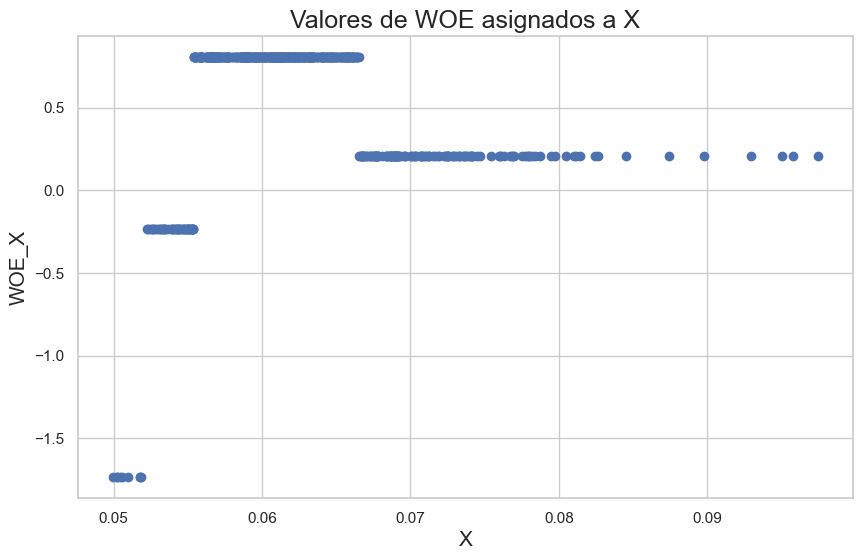

In [26]:
# Configuración de seaborn para mejorar la estética de los gráficos
sns.set(style="whitegrid")

# Crear el gráfico de líneas
plt.figure(figsize=(10, 6))
plt.scatter(x_prueba, assign_woe(x_prueba, woe_values), marker='o', linestyle='-', color='b')

# Títulos y etiquetas
plt.title('Valores de WOE asignados a X', fontsize=18)
plt.xlabel('X', fontsize=15)
plt.ylabel('WOE_X', fontsize=15)

# Mostrar el gráfico
plt.show()

In [27]:
# Crear el modelo de regresión logística
modelo = LogisticRegression(penalty=None)

# Ajustar el modelo con los datos de entrenamiento
modelo.fit(x_prueba.reshape(-1, 1), y_prueba)

# Predecir en los datos de prueba
predicciones = modelo.predict(x_prueba.reshape(-1, 1))

# Evaluar el modelo
accuracy = modelo.score(x_prueba.reshape(-1, 1), y_prueba)
print("Exactitud del modelo:", accuracy)

# Predecir probabilidades en lugar de clases
predicciones_prob = modelo.predict_proba(x_prueba.reshape(-1, 1))[:, 1]

# Calcular el AUC
auc = roc_auc_score(y_prueba, predicciones_prob)
print("Área bajo la curva ROC (AUC):", auc)

Exactitud del modelo: 0.6274165202108963
Área bajo la curva ROC (AUC): 0.5154656202103483


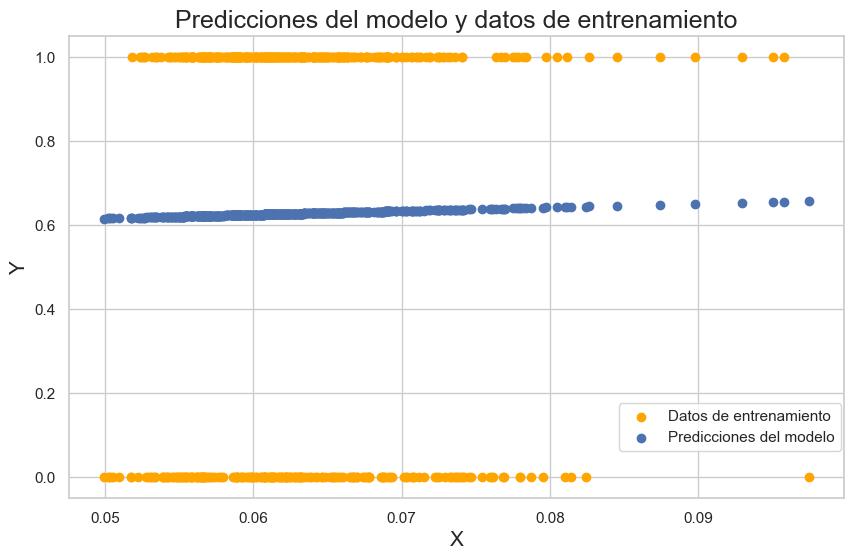

In [28]:
# Configuración de seaborn para mejorar la estética de los gráficos
sns.set(style="whitegrid")

# Crear el gráfico de líneas
plt.figure(figsize=(10, 6))

# Plot de los datos de entrenamiento
plt.scatter(x_prueba.reshape(-1, 1), y_prueba, color='orange', label='Datos de entrenamiento')

# Predicciones del modelo en los datos de entrenamiento
plt.scatter(x_prueba.reshape(-1, 1), predicciones_prob, color='b', label='Predicciones del modelo')

# Añadir etiquetas y leyenda
plt.xlabel('X', fontsize=15)
plt.ylabel('Y', fontsize=15)
plt.title('Predicciones del modelo y datos de entrenamiento', fontsize=18)
plt.legend(bbox_to_anchor=(0.7, 0.085))

# Mostrar el gráfico
plt.show()

In [29]:
modelo.coef_

array([[3.78208989]])

In [30]:
modelo.intercept_

array([0.28373371])

In [31]:
x_woe = assign_woe(x_prueba, woe_values).reshape(-1, 1)

In [32]:
# Crear el modelo de regresión logística
modelo = LogisticRegression(penalty=None)

# Ajustar el modelo con los datos de entrenamiento
modelo.fit(x_woe, y_prueba)

# Predecir en los datos de prueba
predicciones = modelo.predict(x_woe)

# Evaluar el modelo
accuracy = modelo.score(x_woe, y_prueba)
print("Exactitud del modelo:", accuracy)

# Predecir probabilidades en lugar de clases
predicciones_prob_woe = modelo.predict_proba(x_woe)[:, 1]

# Calcular el AUC
auc = roc_auc_score(y_prueba, predicciones_prob_woe)
print("Área bajo la curva ROC (AUC):", auc)

Exactitud del modelo: 0.6502636203866432
Área bajo la curva ROC (AUC): 0.6000211405316843


In [33]:
modelo.coef_

array([[1.03895973]])

In [34]:
modelo.intercept_

array([-0.02178034])

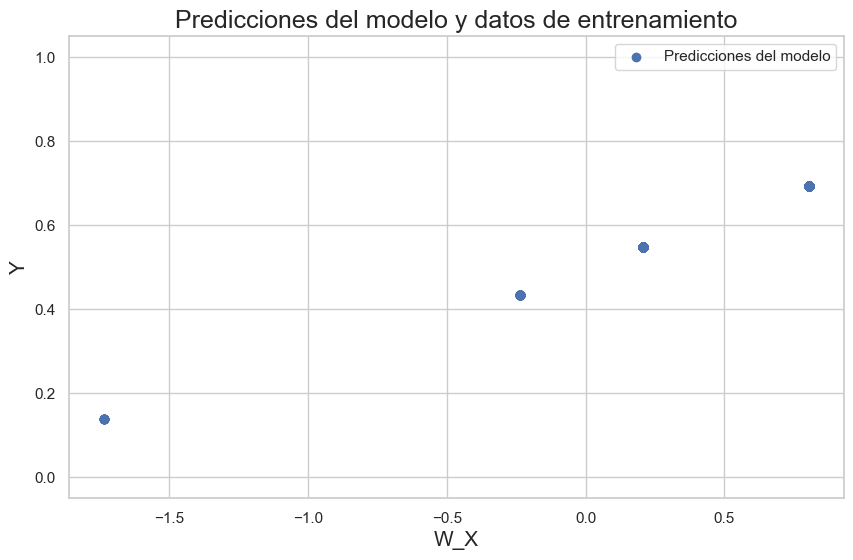

In [35]:
# Configuración de seaborn para mejorar la estética de los gráficos
sns.set(style="whitegrid")

# Crear el gráfico de líneas
plt.figure(figsize=(10, 6))

# Predicciones del modelo en los datos de entrenamiento
plt.scatter(x_woe, predicciones_prob_woe, color='b', label='Predicciones del modelo')

# Añadir etiquetas y leyenda
plt.xlabel('W_X', fontsize=15)
plt.ylabel('Y', fontsize=15)
plt.title('Predicciones del modelo y datos de entrenamiento', fontsize=18)
plt.legend()

# Establecer el límite del eje y
plt.ylim(-0.05, 1.05)

# Mostrar el gráfico
plt.show()

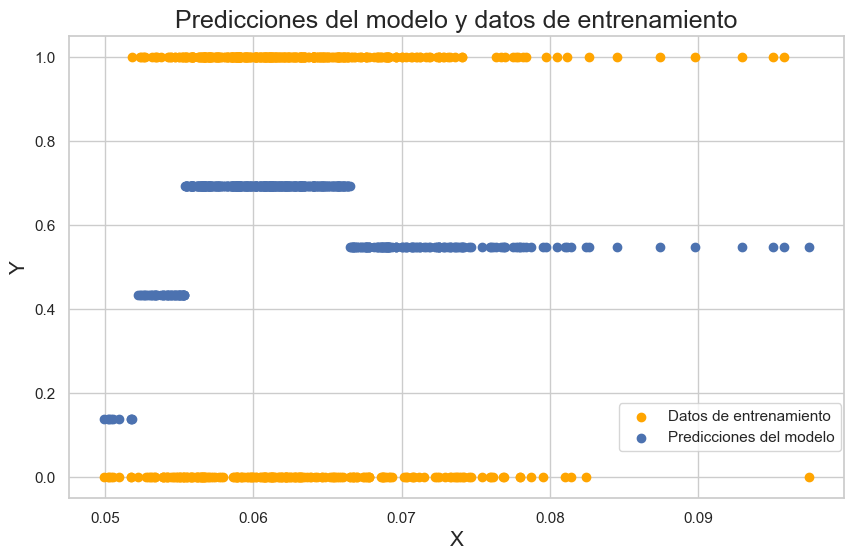

In [36]:
# Configuración de seaborn para mejorar la estética de los gráficos
sns.set(style="whitegrid")

# Crear el gráfico de líneas
plt.figure(figsize=(10, 6))

# Plot de los datos de entrenamiento
plt.scatter(x_prueba.reshape(-1, 1), y_prueba, color='orange', label='Datos de entrenamiento')

# Predicciones del modelo en los datos de entrenamiento
plt.scatter(x_prueba.reshape(-1, 1), predicciones_prob_woe, color='b', label='Predicciones del modelo')

# Añadir etiquetas y leyenda
plt.xlabel('X', fontsize=15)
plt.ylabel('Y', fontsize=15)
plt.title('Predicciones del modelo y datos de entrenamiento', fontsize=18)
plt.legend(bbox_to_anchor=(0.7, 0.085))

# Mostrar el gráfico
plt.show()

In [37]:
def woe(X_train, y_train, X_test):
    X_train_woe = pd.DataFrame()
    X_test_woe = pd.DataFrame()

    for col in X_train.columns:
        print(col)
        tree = DecisionTree(criterion='gini', max_depth=2)
        tree.fit(X_train[col].values, y_train)
        woe_values = tree.calculate_woe(X_train[col].values, y_train)
        
        X_train_woe[f'{col}_woe'] = assign_woe(X_train[col].values, woe_values)
        X_test_woe[f'{col}_woe'] = assign_woe(X_test[col].values, woe_values)
        print('ok')
    return X_train_woe, X_test_woe

## Fuzzy WOE AN (árboles nítidos)

In [38]:
tree = DecisionTree(criterion='gini', max_depth=2)
tree.fit(x_prueba, y_prueba)
tree.print_tree()

NODE | Cardinality = 569 | Split Value: 0.05536 | Label: 0.62742 | 
  NODE | Cardinality = 58 | Split Value: 0.05185 | Label: 0.37931 | 
    LEAF | Label = 0.0
    LEAF | Label = 0.44
  NODE | Cardinality = 511 | Split Value: 0.0665 | Label: 0.65558 | 
    LEAF | Label = 0.69415
    LEAF | Label = 0.54815


In [39]:
tree.calculate_woe(x_prueba, y_prueba)

[((-inf, 0.05185), -1.7346010553881064),
 ((0.05185, 0.05536), -0.2363887780642304),
 ((0.05536, 0.0665), 0.8047115881876664),
 ((0.0665, inf), 0.20815576034871797)]

In [40]:
tree1 = DecisionTree(criterion='gini', max_depth=1)
tree1.fit(x_prueba, y_prueba)
tree1.print_tree()

NODE | Cardinality = 569 | Split Value: 0.05536 | Label: 0.62742 | 
  LEAF | Label = 0.37931
  LEAF | Label = 0.65558


In [41]:
tree1.tree.split_value

0.05536

In [42]:
def v(x, alfa, beta):
    if beta != 0:
        if x < alfa - beta / 2:
            return 1
        elif x > alfa + beta / 2:
            return 0
        else:
            return (alfa + beta / 2 - x) / beta
    else:
        if x < alfa:
            return 1
        else:
            return 0

In [43]:
def error_func(y, x, grado_pertenencia_padre_func, alfa, beta, label_left, label_right):
    error = 0
    for i in range(len(x)):
        mu_prima = v(x[i], alfa, beta) * label_left + (1 - v(x[i], alfa, beta)) * label_right
        error_observacion = grado_pertenencia_padre_func(x[i]) * (y[i] - mu_prima) ** 2
        error += error_observacion
    return error

In [44]:
def fibonacci_search_fixed(f, y_fixed, x_fixed, grado_pertenencia_padre_func_fixed, alfa_fixed, label_left_fixed, label_right_fixed, a, b, epsilon=0.001):
    # Generar la secuencia de Fibonacci hasta que F_n >= (b - a) / epsilon
    fib = [0, 1]
    while fib[-1] < (b - a) / epsilon:
        fib.append(fib[-1] + fib[-2])
    
    n = len(fib) - 1
    
    # Inicializar los puntos
    x1 = a + (fib[n-2] / fib[n]) * (b - a)
    x2 = a + (fib[n-1] / fib[n]) * (b - a)
    
    f1 = f(y_fixed, x_fixed, grado_pertenencia_padre_func_fixed, alfa_fixed, x1, label_left_fixed, label_right_fixed)
    f2 = f(y_fixed, x_fixed, grado_pertenencia_padre_func_fixed, alfa_fixed, x2, label_left_fixed, label_right_fixed)
    
    for k in range(n-1, 1, -1):
        if f1 > f2:
            a = x1
            x1 = x2
            f1 = f2
            x2 = a + (fib[k-1] / fib[k]) * (b - a)
            f2 = f(y_fixed, x_fixed, grado_pertenencia_padre_func_fixed, alfa_fixed, x2, label_left_fixed, label_right_fixed)
        else:
            b = x2
            x2 = x1
            f2 = f1
            x1 = a + (fib[k-2] / fib[k]) * (b - a)
            f1 = f(y_fixed, x_fixed, grado_pertenencia_padre_func_fixed, alfa_fixed, x1, label_left_fixed, label_right_fixed)
    
    # Ajustar el punto final si es necesario
    if f1 < f2:
        return (x1, f1)
    else:
        return (x2, f2)

In [45]:
def grado_pertenencia_padre_func(x):
    return 1

In [46]:
def min_error_split_2(y, x, alfa, grado_pertenencia_padre_func):
    min_error = None
    beta = 0
    
    mask = x < alfa
    
    label_left = sum(grado_pertenencia_padre_func(xi) * yi for xi, yi, bandera in zip(x, y, mask) if bandera) / sum(grado_pertenencia_padre_func(xi) for xi, bandera in zip(x, mask) if bandera)
    label_right = sum(grado_pertenencia_padre_func(xi) * yi for xi, yi, bandera in zip(x, y, mask) if not bandera) / sum(grado_pertenencia_padre_func(xi) for xi, bandera in zip(x, mask) if not bandera)

    min_beta = 0
    max_beta = 2 * min(max(x) - alfa, alfa - min(x)) #quizas ampliar esto
    #Quitar el 2 * mejora las WOE FA, ya que asi no se solapan los beta y no 'baja' el intervalo (ver dibujo de cuando predigo con
    #una sola variable). De todos modos, creo que lo mejor es explicar en la memoria los arboles eligiendo el beta así y
    #luego cuando calculo las woe elegir el mejor beta con validacion. Si no hago lo de validación, quitar el 2* aun asi.
    #max_beta = max(abs(x))
        
    beta, min_error = fibonacci_search_fixed(
        f=error_func,
        y_fixed=y,
        x_fixed=x,
        grado_pertenencia_padre_func_fixed=grado_pertenencia_padre_func,
        alfa_fixed=alfa,
        label_left_fixed=label_left,
        label_right_fixed=label_right,
        a=min_beta,
        b=max_beta,
        epsilon=0.001
    )
    
    def grado_pertenencia_izquierda_func(xi):
        return v(xi, alfa, beta) * grado_pertenencia_padre_func(xi)

    def grado_pertenencia_derecha_func(xi):
        return (1 - v(xi, alfa, beta)) * grado_pertenencia_padre_func(xi)
    
    return {
        "alfa": alfa,
        "beta": beta,
        "grado_pertenencia_izquierda_func": grado_pertenencia_izquierda_func,
        "grado_pertenencia_derecha_func": grado_pertenencia_derecha_func
    }

In [47]:
first_split = min_error_split_2(y_prueba, x_prueba, tree1.tree.split_value, grado_pertenencia_padre_func)
first_split

{'alfa': 0.05536,
 'beta': 0.0033230769230769243,
 'grado_pertenencia_izquierda_func': <function __main__.min_error_split_2.<locals>.grado_pertenencia_izquierda_func(xi)>,
 'grado_pertenencia_derecha_func': <function __main__.min_error_split_2.<locals>.grado_pertenencia_derecha_func(xi)>}

In [48]:
#veamos lo que hay que hacer al nodo de la izquierda y al de la derecha:
left_mask = x_prueba < first_split['alfa']
right_mask = ~left_mask

In [49]:
tree2l = DecisionTree(criterion='gini', max_depth=1)
tree2l.fit(x_prueba[left_mask], y_prueba[left_mask])
tree2l.print_tree()

NODE | Cardinality = 58 | Split Value: 0.05185 | Label: 0.37931 | 
  LEAF | Label = 0.0
  LEAF | Label = 0.44


In [50]:
min_error_split_2(y_prueba[left_mask], x_prueba[left_mask], tree2l.tree.split_value, first_split['grado_pertenencia_izquierda_func'])

{'alfa': 0.05185,
 'beta': 0.0,
 'grado_pertenencia_izquierda_func': <function __main__.min_error_split_2.<locals>.grado_pertenencia_izquierda_func(xi)>,
 'grado_pertenencia_derecha_func': <function __main__.min_error_split_2.<locals>.grado_pertenencia_derecha_func(xi)>}

In [51]:
tree2r = DecisionTree(criterion='gini', max_depth=1)
tree2r.fit(x_prueba[right_mask], y_prueba[right_mask])

In [52]:
min_error_split_2(y_prueba[right_mask], x_prueba[right_mask], tree2r.tree.split_value, first_split['grado_pertenencia_derecha_func'])

{'alfa': 0.0665,
 'beta': 0.015071764705882357,
 'grado_pertenencia_izquierda_func': <function __main__.min_error_split_2.<locals>.grado_pertenencia_izquierda_func(xi)>,
 'grado_pertenencia_derecha_func': <function __main__.min_error_split_2.<locals>.grado_pertenencia_derecha_func(xi)>}

In [53]:
def fuzzy_fixed_alfas(x_prueba, y_prueba, grado_pertenencia_padre_func):
    y_pueba = np.array(y_prueba)
    
    tree1 = DecisionTree(criterion='gini', max_depth=1)
    tree1.fit(x_prueba, y_prueba)
    first_split = min_error_split_2(y_prueba, x_prueba, tree1.tree.split_value, grado_pertenencia_padre_func)
    
    left_mask = x_prueba < first_split['alfa']
    right_mask = ~left_mask
    
    tree2l = DecisionTree(criterion='gini', max_depth=1)
    tree2l.fit(x_prueba[left_mask], y_prueba[left_mask])
    second_split_left = min_error_split_2(y_prueba[left_mask], x_prueba[left_mask], tree2l.tree.split_value, first_split['grado_pertenencia_izquierda_func'])
    
    tree2r = DecisionTree(criterion='gini', max_depth=1)
    tree2r.fit(x_prueba[right_mask], y_prueba[right_mask])
    second_split_right = min_error_split_2(y_prueba[right_mask], x_prueba[right_mask], tree2r.tree.split_value, first_split['grado_pertenencia_derecha_func'])
    
    #con los tres cortes, calculo las WOE normales en esos intervalos y luego pondero con el grado de pertenencia:
    splits = [second_split_left['alfa'], first_split['alfa'], second_split_right['alfa']]
    
    intervals = [(float('-inf'), splits[0]), (splits[0], splits[1]), (splits[1], splits[2]), (splits[2], float('inf'))]

    woe_values = []
    for interval in intervals:
        mask = (x_prueba > interval[0]) & (x_prueba <= interval[1])
        good = np.sum(y_prueba[mask] == 1)
        bad = np.sum(y_prueba[mask] == 0)
        # total_good = np.sum(y_prueba == 1)
        # total_bad = np.sum(y_prueba == 0)
        # woe = np.log(((good+0.5) / (total_good+0.5)) / ((bad+0.5) / (total_bad+0.5)))
        woe = np.log((good+0.5) / (bad+0.5))
        woe_values.append((interval, woe))
    
    def woe_function(x):
        woe_pond = second_split_left['grado_pertenencia_izquierda_func'](x) * woe_values[0][1] + \
                   second_split_left['grado_pertenencia_derecha_func'](x) * woe_values[1][1] + \
                   second_split_right['grado_pertenencia_izquierda_func'](x) * woe_values[2][1] + \
                   second_split_right['grado_pertenencia_derecha_func'](x) * woe_values[3][1]
        return woe_pond
    
    return {'woe_values': woe_values, 
            'funciones_grado_pertenencia': [second_split_left['grado_pertenencia_izquierda_func'], second_split_left['grado_pertenencia_derecha_func'],
                                            second_split_right['grado_pertenencia_izquierda_func'], second_split_right['grado_pertenencia_derecha_func']],
            'woe_function': woe_function
           }

In [54]:
fuzzy_woe_fixed_alfas = fuzzy_fixed_alfas(x_prueba, y_prueba, grado_pertenencia_padre_func)
fuzzy_woe_fixed_alfas

{'woe_values': [((-inf, 0.05185), -1.7346010553881064),
  ((0.05185, 0.05536), -0.2363887780642304),
  ((0.05536, 0.0665), 0.8047115881876664),
  ((0.0665, inf), 0.20815576034871797)],
 'funciones_grado_pertenencia': [<function __main__.min_error_split_2.<locals>.grado_pertenencia_izquierda_func(xi)>,
  <function __main__.min_error_split_2.<locals>.grado_pertenencia_derecha_func(xi)>,
  <function __main__.min_error_split_2.<locals>.grado_pertenencia_izquierda_func(xi)>,
  <function __main__.min_error_split_2.<locals>.grado_pertenencia_derecha_func(xi)>],
 'woe_function': <function __main__.fuzzy_fixed_alfas.<locals>.woe_function(x)>}

In [55]:
def plot_grados_pertenencia_fuzzy_woe_fixed_alfas(fuzzy_woe_fixed_alfas, x_range):
    sns.set(style="whitegrid")
    
    plt.figure(figsize=(10, 6))

    i = 0
    for funcion in fuzzy_woe_fixed_alfas['funciones_grado_pertenencia']:
        membership_values = [funcion(xi) for xi in x_range]
        woe_value = fuzzy_woe_fixed_alfas['woe_values'][i][1]
        plt.plot(x_range, membership_values, label=f'WOE = {woe_value:.2f}')
        i += 1
        
    plt.xlabel('X', fontsize=15)
    plt.ylabel('Grado de pertenencia', fontsize=15)
    plt.legend()
    plt.grid(True)
    plt.show()

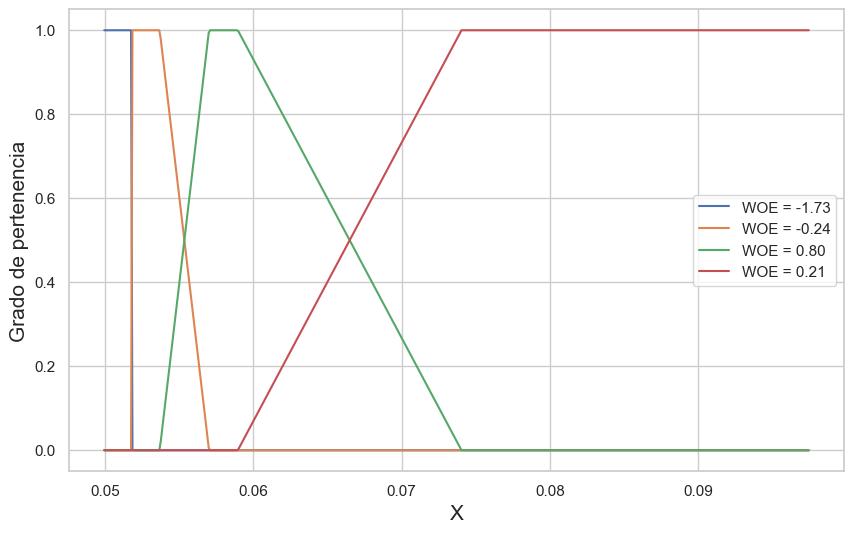

In [56]:
x_range = np.linspace(min(x_prueba), max(x_prueba), 500)
plot_grados_pertenencia_fuzzy_woe_fixed_alfas(fuzzy_woe_fixed_alfas, x_range)

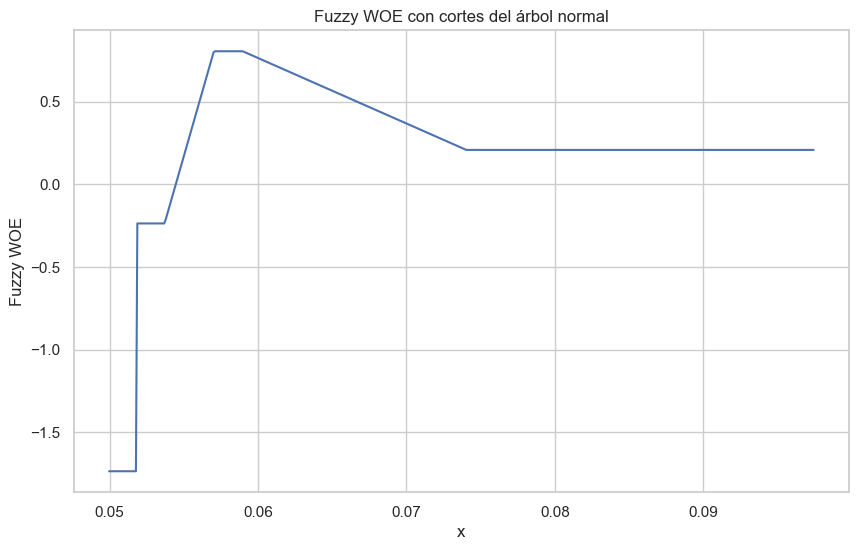

In [57]:
plt.figure(figsize=(10, 6))
plt.plot(x_range, [fuzzy_woe_fixed_alfas['woe_function'](xi) for xi in x_range])
plt.xlabel('x')
plt.ylabel('Fuzzy WOE')
plt.title('Fuzzy WOE con cortes del árbol normal')
plt.grid(True)
plt.show()

In [58]:
x_woe_and = np.array([fuzzy_woe_fixed_alfas['woe_function'](xi) for xi in x_prueba]).reshape(-1,1)

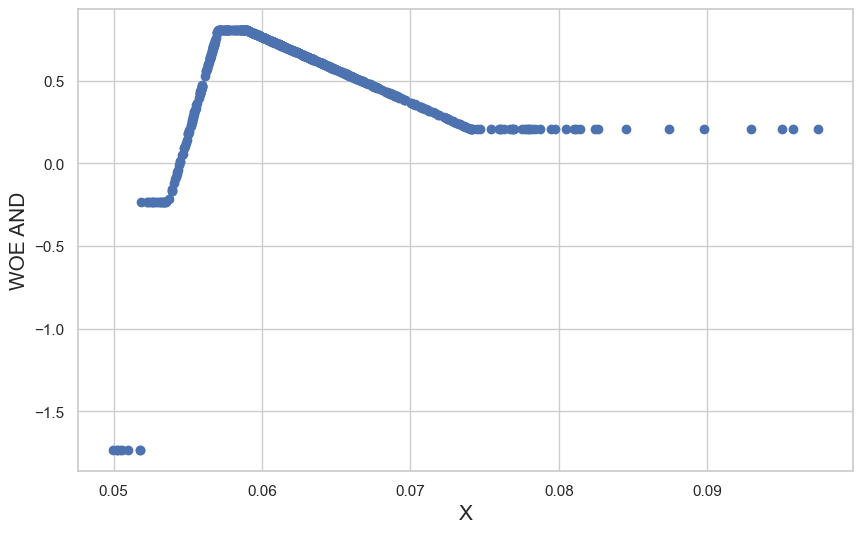

In [59]:
# Configuración de seaborn para mejorar la estética de los gráficos
sns.set(style="whitegrid")

# Crear el gráfico de líneas
plt.figure(figsize=(10, 6))
plt.scatter(x_prueba, x_woe_and)

# Títulos y etiquetas
plt.xlabel('X', fontsize=15)
plt.ylabel('WOE AND', fontsize=15)

# Mostrar el gráfico
plt.show()

In [60]:
# Crear el modelo de regresión logística
modelo = LogisticRegression(penalty=None)

# Ajustar el modelo con los datos de entrenamiento
modelo.fit(x_woe_and, y_prueba)

# Predecir en los datos de prueba
predicciones = modelo.predict(x_woe_and)

# Evaluar el modelo
accuracy = modelo.score(x_woe_and, y_prueba)
print("Exactitud del modelo:", accuracy)

# Predecir probabilidades en lugar de clases
predicciones_prob_woe_and = modelo.predict_proba(x_woe_and)[:, 1]

# Calcular el AUC
auc = roc_auc_score(y_prueba, predicciones_prob_woe_and)
print("Área bajo la curva ROC (AUC):", auc)

Exactitud del modelo: 0.6467486818980668
Área bajo la curva ROC (AUC): 0.6162861370963479


In [61]:
modelo.coef_

array([[1.44345918]])

In [62]:
modelo.intercept_

array([-0.1932147])

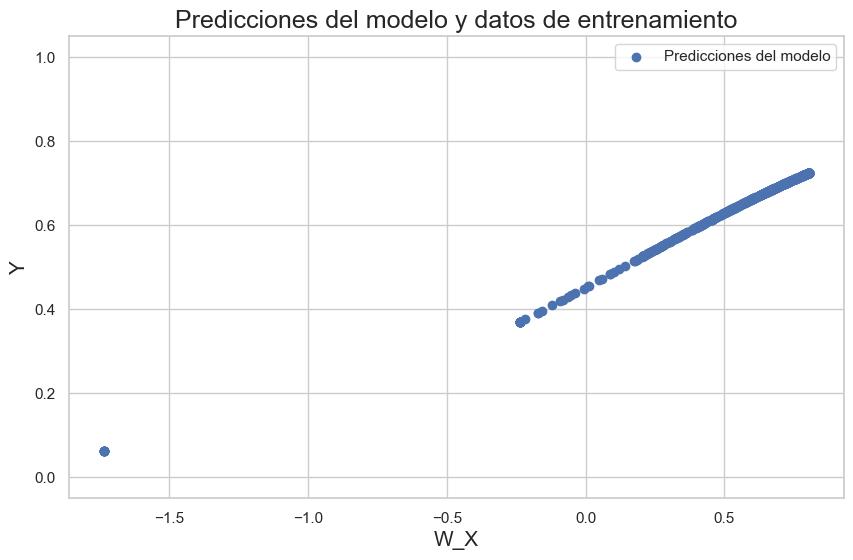

In [63]:
# Configuración de seaborn para mejorar la estética de los gráficos
sns.set(style="whitegrid")

# Crear el gráfico de líneas
plt.figure(figsize=(10, 6))

# Predicciones del modelo en los datos de entrenamiento
plt.scatter(x_woe_and, predicciones_prob_woe_and, color='b', label='Predicciones del modelo')

# Añadir etiquetas y leyenda
plt.xlabel('W_X', fontsize=15)
plt.ylabel('Y', fontsize=15)
plt.title('Predicciones del modelo y datos de entrenamiento', fontsize=18)
plt.legend()

# Establecer el límite del eje y
plt.ylim(-0.05, 1.05)

# Mostrar el gráfico
plt.show()

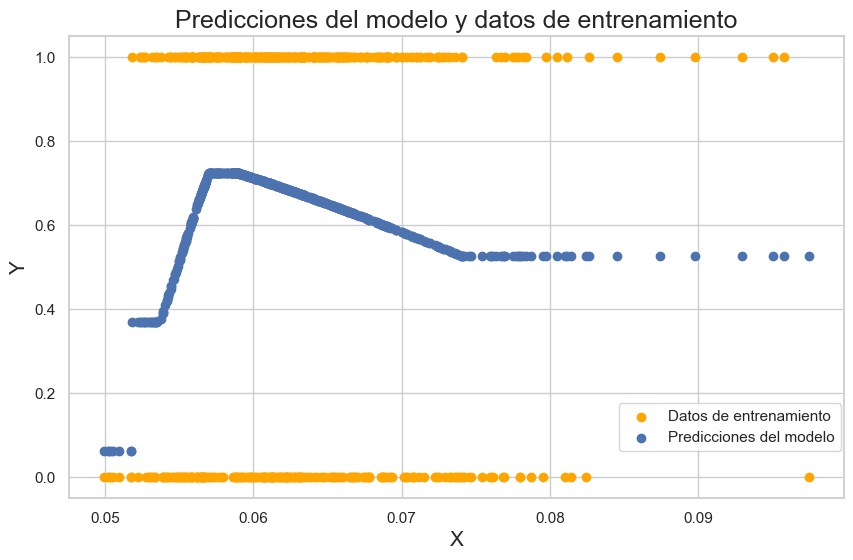

In [64]:
# Configuración de seaborn para mejorar la estética de los gráficos
sns.set(style="whitegrid")

# Crear el gráfico de líneas
plt.figure(figsize=(10, 6))

# Plot de los datos de entrenamiento
plt.scatter(x_prueba.reshape(-1, 1), y_prueba, color='orange', label='Datos de entrenamiento')

# Predicciones del modelo en los datos de entrenamiento
plt.scatter(x_prueba.reshape(-1, 1), predicciones_prob_woe_and, color='b', label='Predicciones del modelo')

# Añadir etiquetas y leyenda
plt.xlabel('X', fontsize=15)
plt.ylabel('Y', fontsize=15)
plt.title('Predicciones del modelo y datos de entrenamiento', fontsize=18)
plt.legend(bbox_to_anchor=(0.7, 0.085))

# Mostrar el gráfico
plt.show()

In [65]:
def fuzzy_woe_fixed_alfas_df(X_train, y_train, X_test):
    X_train_fuzzy_woe_fa = pd.DataFrame()
    X_test_fuzzy_woe_fa = pd.DataFrame()
    y_train = np.array(y_train)
    for col in X_train.columns:
        print(col)
        fuzzy_woe_fa = fuzzy_fixed_alfas(X_train[col].values, y_train, grado_pertenencia_padre_func)
        
        # Calculate WOE for X_train
        X_train_fuzzy_woe_fa[f'{col}_fuzzy_woe_fa'] = X_train[col].apply(fuzzy_woe_fa['woe_function'])

        # Calculate WOE for X_test
        X_test_fuzzy_woe_fa[f'{col}_fuzzy_woe_fa'] = X_test[col].apply(fuzzy_woe_fa['woe_function'])
        print('ok')
    return X_train_fuzzy_woe_fa, X_test_fuzzy_woe_fa

## Fuzzy WOE AD (árboles difusos)

Fuzzy Decission Tree functions

In [66]:
def min_error_split(y, x, grado_pertenencia_padre_func, fuzzy=True):
    min_error = None
    alfa = None
    beta = 0
    
    #Elijo como posibles alfas los x's que tengan un grado de pertenencia positivo al nodo
    lista_posibles_alfas = np.unique(np.sort(x[np.array([grado_pertenencia_padre_func(xi) for xi in x]) > 0]))
        
    for posible_alfa in lista_posibles_alfas[1:]:
        
        mask = x < posible_alfa
        
        label_left = sum(grado_pertenencia_padre_func(xi) * yi for xi, yi, bandera in zip(x, y, mask) if bandera) / sum(grado_pertenencia_padre_func(xi) for xi, bandera in zip(x, mask) if bandera)
        label_right = sum(grado_pertenencia_padre_func(xi) * yi for xi, yi, bandera in zip(x, y, mask) if not bandera) / sum(grado_pertenencia_padre_func(xi) for xi, bandera in zip(x, mask) if not bandera)
        
        error = error_func(y, x, grado_pertenencia_padre_func, posible_alfa, beta, label_left, label_right)

        if min_error is None or error < min_error:
            min_error = error
            alfa = posible_alfa
            label_left_ok = label_left
            label_right_ok = label_right

    if fuzzy:
        min_beta = 0
        max_beta = 2 * min(max(x) - alfa, alfa - min(x))
        
        beta, min_error = fibonacci_search_fixed(
            f=error_func,
            y_fixed=y,
            x_fixed=x,
            grado_pertenencia_padre_func_fixed=grado_pertenencia_padre_func,
            alfa_fixed=alfa,
            label_left_fixed=label_left_ok,
            label_right_fixed=label_right_ok,
            a=min_beta,
            b=max_beta,
            epsilon=0.001
        )
    
    def grado_pertenencia_izquierda_func(xi):
        return v(xi, alfa, beta) * grado_pertenencia_padre_func(xi)

    def grado_pertenencia_derecha_func(xi):
        return (1 - v(xi, alfa, beta)) * grado_pertenencia_padre_func(xi)
    
    return {
        "alfa": alfa,
        "beta": beta,
        "grado_pertenencia_izquierda_func": grado_pertenencia_izquierda_func,
        "grado_pertenencia_derecha_func": grado_pertenencia_derecha_func
    }

In [67]:
class FuzzyNode:
    def __init__(self, is_leaf=True, alfa=None, beta=None, label=None, fuzzy_woe=None, grado_pertenencia_func=None, cardinality = None, node_error=None):
        self.is_leaf = is_leaf
        self.alfa = alfa
        self.beta = beta
        self.label = label
        self.fuzzy_woe = fuzzy_woe
        self.grado_pertenencia_func = grado_pertenencia_func
        self.cardinality = cardinality
        self.node_error = node_error 
        self.left = None
        self.right = None
        
    def node_def(self) -> str:
        if self.is_leaf:
            return f"LEAF | Label = {round(self.label, 5)} | Fuzzy WOE = {round(self.fuzzy_woe, 5)}"
        else:
            return (f"NODE | Cardinality = {round(self.cardinality, 5)} | "
                    f"Node Error = {round(self.node_error, 5)} | "
                    f"Alfa: {round(self.alfa, 5)} | "
                    f"Beta: {round(self.beta, 5)} | "
                    f"Label: {round(self.label, 5)} | "
                    f"Fuzzy WOE = {round(self.fuzzy_woe, 5)}")

In [68]:
class FuzzyDecisionTree:
    def __init__(self, max_depth): 
        self.root = None
        self.max_depth = max_depth

    def fit(self, y, x, grado_pertenencia_padre_func, fuzzy):
        self.root = self._grow_tree(y, x, grado_pertenencia_padre_func, fuzzy, depth=0)

    def _grow_tree(self, y, x, grado_pertenencia_padre_func, fuzzy, depth):
        node = FuzzyNode()
        
        node.grado_pertenencia_func = grado_pertenencia_padre_func
        node.label = sum(grado_pertenencia_padre_func(xi) * yi for xi, yi in zip(x, y)) / sum(grado_pertenencia_padre_func(xi) for xi in x)
        
        
        node.fuzzy_woe = np.log(((sum(grado_pertenencia_padre_func(xi)*yi for xi, yi in zip(x, y)))+0.5) /
        (((sum(grado_pertenencia_padre_func(xi) for xi in x) - sum(grado_pertenencia_padre_func(xi)*yi for xi, yi in zip(x, y)))+0.5)))
        
        node.cardinality = sum(grado_pertenencia_padre_func(xi) for xi in x)
        node.node_error = sum(grado_pertenencia_padre_func(xi) * (yi - node.label)**2 for xi, yi in zip(x, y)) 
        
        unique_positive_memberships = np.unique(np.sort(x[np.array([grado_pertenencia_padre_func(xi) for xi in x]) > 0]))
        if len(unique_positive_memberships) <= 1:
            node.is_leaf = True
            return node
        
        # Perform the split using min_error_split
        split_result = min_error_split(y, x, grado_pertenencia_padre_func, fuzzy)
        
        node.alfa = split_result['alfa']
        node.beta = split_result['beta']

        # Determine if the node is a leaf or should be split further
        if depth < self.max_depth and self._should_split(node, x):
            node.is_leaf = False 

            # Recursive splitting for left and right child nodes
            node.left = self._grow_tree(y, x, split_result['grado_pertenencia_izquierda_func'], fuzzy, depth+1)
            node.right = self._grow_tree(y, x, split_result['grado_pertenencia_derecha_func'], fuzzy, depth+1)
        
        return node

    def _should_split(self, node, x):
        return node.cardinality > 0.01*len(x) and node.node_error > 1
    
    def collect_leaf_nodes(self):
        leaves = []
        self._collect_leaf_nodes(self.root, leaves)
        return leaves

    def _collect_leaf_nodes(self, node, leaves):
        if node.is_leaf:
            leaves.append(node)
        else:
            if node.left is not None:
                self._collect_leaf_nodes(node.left, leaves)
            if node.right is not None:
                self._collect_leaf_nodes(node.right, leaves)
                
    def collect_no_leaf_nodes(self):
        no_leaves = []
        self._collect_no_leaf_nodes(self.root, no_leaves)
        return no_leaves
                
    def _collect_no_leaf_nodes(self, node, no_leaves):
        if not node.is_leaf:
            no_leaves.append(node)
            if node.left is not None:
                self._collect_no_leaf_nodes(node.left, no_leaves)
            if node.right is not None:
                self._collect_no_leaf_nodes(node.right, no_leaves)
                
    def _predict_single(self, x):
        leaves = self.collect_leaf_nodes()
        prediction = sum(node.label*node.grado_pertenencia_func(x) for node in leaves)
        return prediction
    
    def predict(self, x):
        return [self._predict_single(xi) for xi in x]
    
    def _predict_single_fuzzy_woe(self, x):
        leaves = self.collect_leaf_nodes()
        prediction = sum(node.fuzzy_woe*node.grado_pertenencia_func(x) for node in leaves)
        return prediction
    
    def predict_fuzzy_woe(self, x):
        return [self._predict_single_fuzzy_woe(xi) for xi in x]

**Prueba del funcionamiento con una variable**

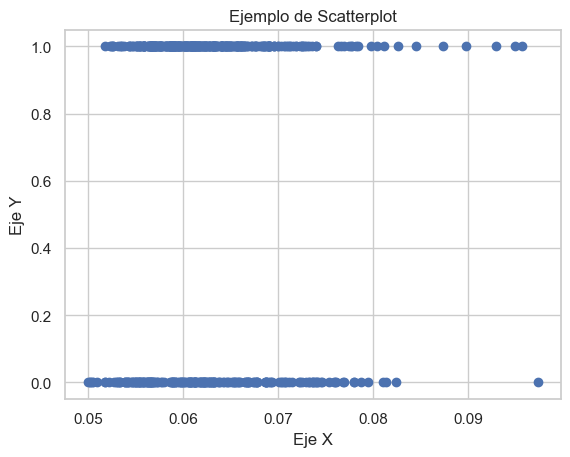

In [69]:
# Crear el scatterplot
plt.scatter(x_prueba, y_prueba)

# Etiquetas de los ejes
plt.xlabel('Eje X')
plt.ylabel('Eje Y')

# Título del gráfico
plt.title('Ejemplo de Scatterplot')

# Mostrar el gráfico
plt.show()

In [70]:
fdt = FuzzyDecisionTree(max_depth=2)

In [71]:
fdt.fit(y_prueba, x_prueba, grado_pertenencia_padre_func, fuzzy=True)

In [72]:
def print_tree(node, margen=0):
    if node is not None:
        print("-" * margen + node.node_def())
        if not node.is_leaf:
            print_tree(node.left, margen + 1)
            print_tree(node.right, margen + 1)

In [73]:
print_tree(fdt.root)

NODE | Cardinality = 569 | Node Error = 133.0123 | Alfa: 0.05536 | Beta: 0.00332 | Label: 0.62742 | Fuzzy WOE = 0.52019
-NODE | Cardinality = 62.48912 | Node Error = 15.29053 | Alfa: 0.05185 | Beta: 0.0 | Label: 0.42714 | Fuzzy WOE = -0.28885
--LEAF | Label = 0.0 | Fuzzy WOE = -2.83321
--LEAF | Label = 0.48985 | Fuzzy WOE = -0.03988
-NODE | Cardinality = 506.51088 | Node Error = 114.90599 | Alfa: 0.0665 | Beta: 0.01459 | Label: 0.65213 | Fuzzy WOE = 0.62707
--LEAF | Label = 0.67622 | Fuzzy WOE = 0.73412
--LEAF | Label = 0.60127 | Fuzzy WOE = 0.40819


In [74]:
tree = DecisionTree(criterion='gini', max_depth=2)
tree.fit(x_prueba, y_prueba)
tree.print_tree()

NODE | Cardinality = 569 | Split Value: 0.05536 | Label: 0.62742 | 
  NODE | Cardinality = 58 | Split Value: 0.05185 | Label: 0.37931 | 
    LEAF | Label = 0.0
    LEAF | Label = 0.44
  NODE | Cardinality = 511 | Split Value: 0.0665 | Label: 0.65558 | 
    LEAF | Label = 0.69415
    LEAF | Label = 0.54815


In [75]:
def plot_membership_functions(tree, x_range):
    sns.set(style="whitegrid")
    
    plt.figure(figsize=(10, 6))
    
    leaf_nodes = tree.collect_leaf_nodes()
        
    for node in leaf_nodes:
        membership_values = [node.grado_pertenencia_func(xi) for xi in x_range]
        plt.plot(x_range, membership_values, label=f'WOE AD = {node.fuzzy_woe:.2f}')
    
    plt.xlabel('X', fontsize=15)
    plt.ylabel('Grado de pertenencia', fontsize=15)
    plt.legend()
    plt.grid(True)
    plt.show()

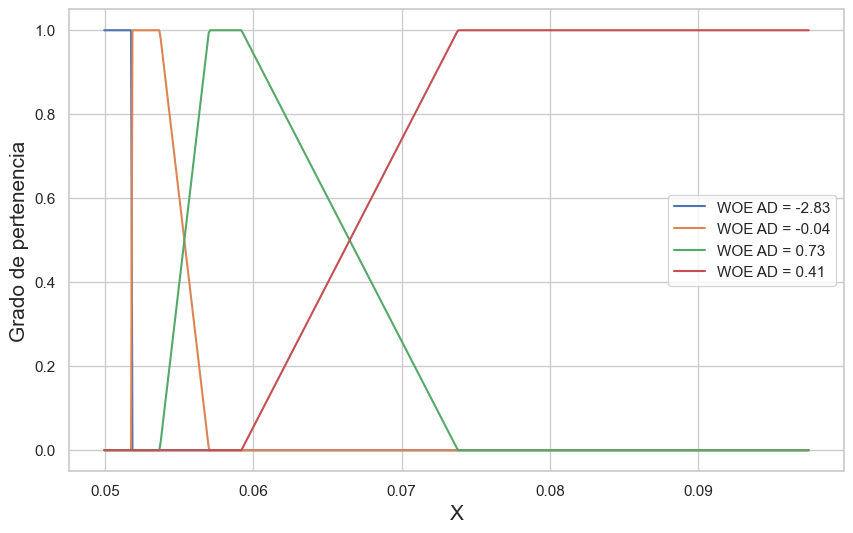

In [76]:
# Define the range of x values for plotting
x_range = np.linspace(min(x_prueba), max(x_prueba), 500)

# Plot the membership functions
plot_membership_functions(fdt, x_range)

In [77]:
#Cálculo de las fuzzy_woe de esta variable

x_woe_ad = fdt.predict_fuzzy_woe(x_prueba)
x_woe_ad = np.array(x_woe_ad).reshape(-1,1)

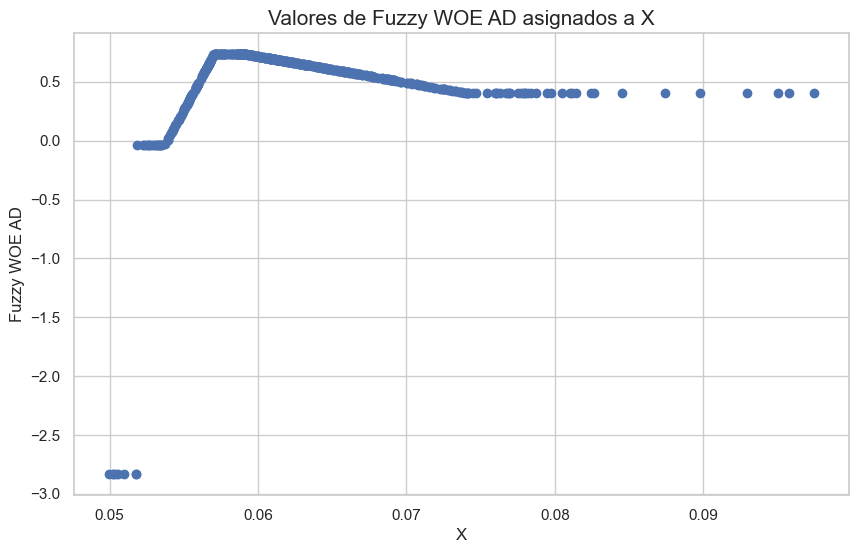

In [78]:
# Configuración de seaborn para mejorar la estética de los gráficos
sns.set(style="whitegrid")

# Crear el gráfico de líneas
plt.figure(figsize=(10, 6))
plt.scatter(x_prueba, x_woe_ad)

# Títulos y etiquetas
plt.title('Valores de Fuzzy WOE AD asignados a X', fontsize=15)
plt.xlabel('X', fontsize=12)
plt.ylabel('Fuzzy WOE AD', fontsize=12)

# Mostrar el gráfico
plt.show()

In [79]:
# Crear el modelo de regresión logística
modelo = LogisticRegression(penalty=None)

# Ajustar el modelo con los datos de entrenamiento
modelo.fit(x_woe_ad, y_prueba)

# Predecir en los datos de prueba
predicciones = modelo.predict(x_woe_ad)

# Evaluar el modelo
accuracy = modelo.score(x_woe_ad, y_prueba)
print("Exactitud del modelo:", accuracy)

# Predecir probabilidades en lugar de clases
predicciones_prob_woe_ad = modelo.predict_proba(x_woe_ad)[:, 1]

# Calcular el AUC
auc = roc_auc_score(y_prueba, predicciones_prob_woe_ad)
print("Área bajo la curva ROC (AUC):", auc)

Exactitud del modelo: 0.648506151142355
Área bajo la curva ROC (AUC): 0.6180632630410655


In [80]:
modelo.coef_

array([[1.84085812]])

In [81]:
modelo.intercept_

array([-0.4689715])

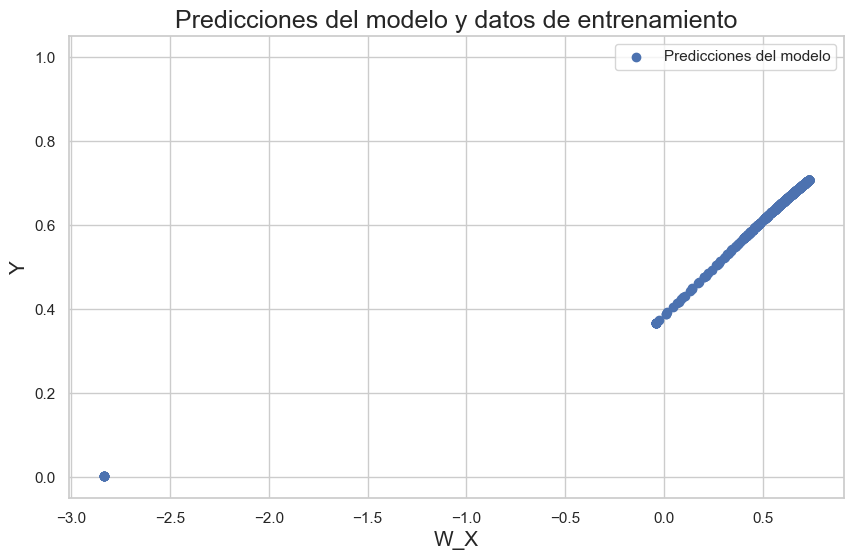

In [82]:
# Configuración de seaborn para mejorar la estética de los gráficos
sns.set(style="whitegrid")

# Crear el gráfico de líneas
plt.figure(figsize=(10, 6))

# Predicciones del modelo en los datos de entrenamiento
plt.scatter(x_woe_ad, predicciones_prob_woe_ad, color='b', label='Predicciones del modelo')

# Añadir etiquetas y leyenda
plt.xlabel('W_X', fontsize=15)
plt.ylabel('Y', fontsize=15)
plt.title('Predicciones del modelo y datos de entrenamiento', fontsize=18)
plt.legend()

# Establecer el límite del eje y
plt.ylim(-0.05, 1.05)

# Mostrar el gráfico
plt.show()

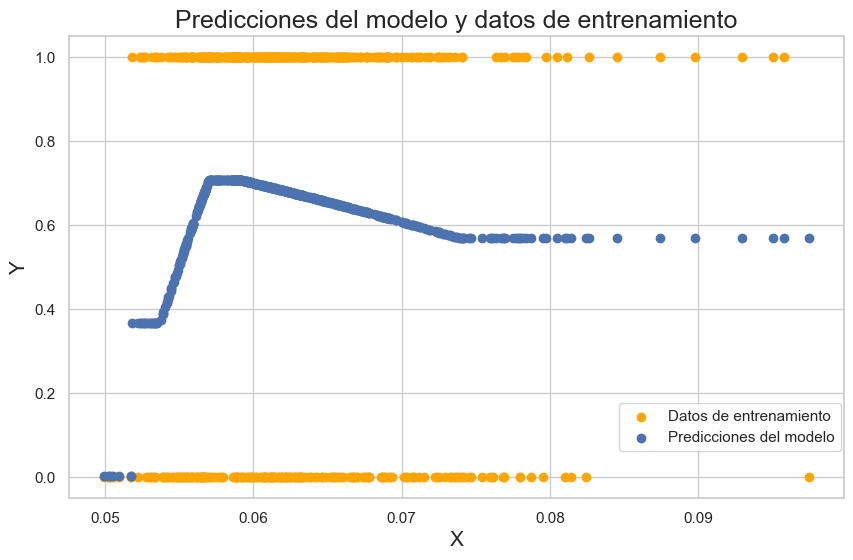

In [83]:
# Configuración de seaborn para mejorar la estética de los gráficos
sns.set(style="whitegrid")

# Crear el gráfico de líneas
plt.figure(figsize=(10, 6))

# Plot de los datos de entrenamiento
plt.scatter(x_prueba.reshape(-1, 1), y_prueba, color='orange', label='Datos de entrenamiento')

# Predicciones del modelo en los datos de entrenamiento
plt.scatter(x_prueba.reshape(-1, 1), predicciones_prob_woe_ad, color='b', label='Predicciones del modelo')

# Añadir etiquetas y leyenda
plt.xlabel('X', fontsize=15)
plt.ylabel('Y', fontsize=15)
plt.title('Predicciones del modelo y datos de entrenamiento', fontsize=18)
plt.legend(bbox_to_anchor=(0.7, 0.085))

# Mostrar el gráfico
plt.show()

In [84]:
#Cálculo de predicciones de esta variable segun el arbol difuso

y_pred = fdt.predict(x_prueba)

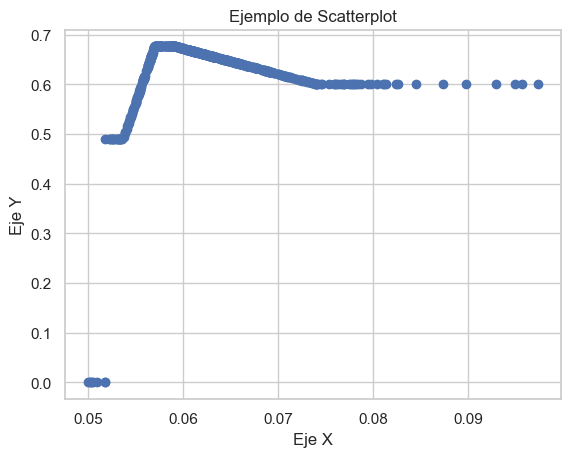

In [85]:
# Crear el scatterplot
plt.scatter(x_prueba, y_pred)

# Etiquetas de los ejes
plt.xlabel('Eje X')
plt.ylabel('Eje Y')

# Título del gráfico
plt.title('Ejemplo de Scatterplot')

# Mostrar el gráfico
plt.show()

Funcion para calcular las WOE de un dataset

In [86]:
def fuzzy_woe(X_train, y_train, X_test): #X_train y X_test tienen que tener las mismas columnas
    y_train = np.array(y_train)
    fuzzy_woe_train = pd.DataFrame()
    fuzzy_woe_test = pd.DataFrame()
    for column in X_train.columns:
        print(column)
        column_data_train = X_train[[column]].values.flatten()
        column_data_test = X_test[[column]].values.flatten()
        fdt = FuzzyDecisionTree(max_depth=2)
        fdt.fit(y_train, column_data_train, grado_pertenencia_padre_func, fuzzy=True)
        fuzzy_woe_train[column + '_fuzzy_woe'] = fdt.predict(column_data_train)
        fuzzy_woe_test[column + '_fuzzy_woe'] = fdt.predict(column_data_test)
        print('ok')
    return fuzzy_woe_train, fuzzy_woe_test

### Dibujo de las tres WOE

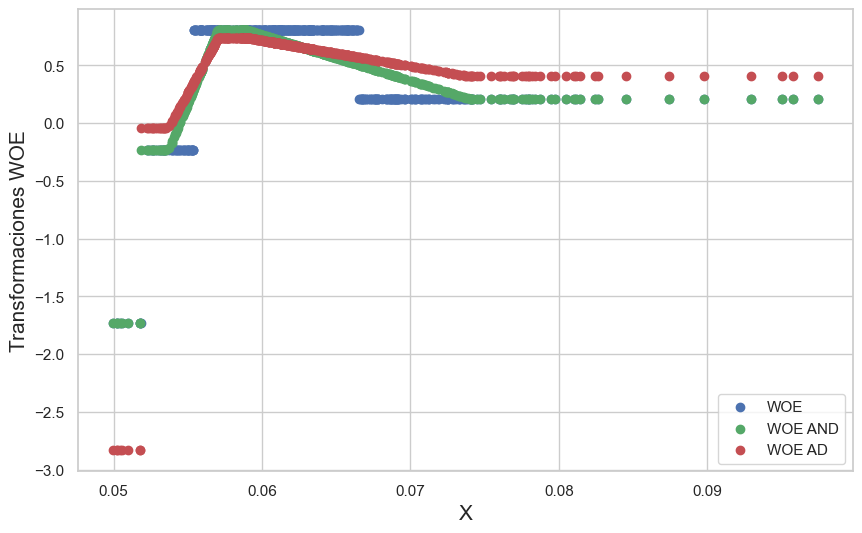

In [87]:
# Configuración de seaborn para mejorar la estética de los gráficos
sns.set(style="whitegrid")

# Crear el gráfico de líneas
plt.figure(figsize=(10, 6))

# Graficar cada conjunto de datos con diferentes colores y etiquetas
plt.scatter(x_prueba, x_woe, color='b', label='WOE')
plt.scatter(x_prueba, x_woe_and, color='g', label='WOE AND')
plt.scatter(x_prueba, x_woe_ad, color='r', label='WOE AD')

# Títulos y etiquetas
plt.xlabel('X', fontsize=15)
plt.ylabel('Transformaciones WOE', fontsize=15)

# Añadir la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

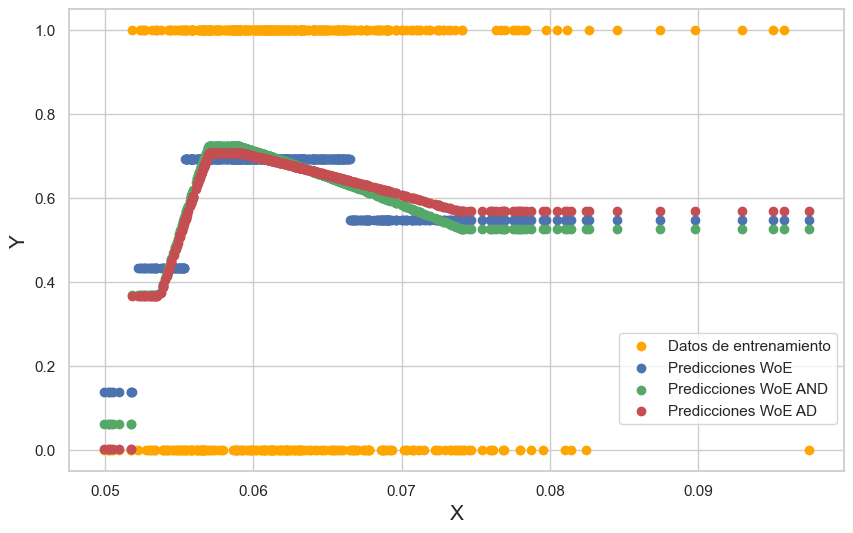

In [88]:
# Configuración de seaborn para mejorar la estética de los gráficos
sns.set(style="whitegrid")

# Crear el gráfico de líneas
plt.figure(figsize=(10, 6))

# Plot de los datos de entrenamiento
plt.scatter(x_prueba.reshape(-1, 1), y_prueba, color='orange', label='Datos de entrenamiento')

# Predicciones del modelo en los datos de entrenamiento
plt.scatter(x_prueba.reshape(-1, 1), predicciones_prob_woe, color='b', label='Predicciones WoE')
plt.scatter(x_prueba.reshape(-1, 1), predicciones_prob_woe_and, color='g', label='Predicciones WoE AND')
plt.scatter(x_prueba.reshape(-1, 1), predicciones_prob_woe_ad, color='r', label='Predicciones WoE AD')

# Añadir etiquetas y leyenda
plt.xlabel('X', fontsize=15)
plt.ylabel('Y', fontsize=15)
plt.legend(bbox_to_anchor=(0.7, 0.085))

# Mostrar el gráfico
plt.show()

## Aplicación de diversos modelos a un dataset dividiendo en train y test: Regresion logística a las variables sin transformar, a las woe, las fuzzy woe AN y las fuzzy woe AD. XGBoost, Random Forest

In [89]:
breast_cancerDF

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,cancer
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0.0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0.0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0.0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0.0


In [90]:
X = breast_cancerDF.drop('cancer', axis=1)
X

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [91]:
y = breast_cancerDF['cancer']
y

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
564    0.0
565    0.0
566    0.0
567    0.0
568    1.0
Name: cancer, Length: 569, dtype: float64

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [93]:
X_train

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
546,10.32,16.35,65.31,324.9,0.09434,0.04994,0.01012,0.005495,0.1885,0.06201,...,11.25,21.77,71.12,384.9,0.1285,0.08842,0.04384,0.02381,0.2681,0.07399
432,20.18,19.54,133.80,1250.0,0.11330,0.14890,0.21330,0.125900,0.1724,0.06053,...,22.03,25.07,146.00,1479.0,0.1665,0.29420,0.53080,0.21730,0.3032,0.08075
174,10.66,15.15,67.49,349.6,0.08792,0.04302,0.00000,0.000000,0.1928,0.05975,...,11.54,19.20,73.20,408.3,0.1076,0.06791,0.00000,0.00000,0.2710,0.06164
221,13.56,13.90,88.59,561.3,0.10510,0.11920,0.07860,0.044510,0.1962,0.06303,...,14.98,17.13,101.10,686.6,0.1376,0.26980,0.25770,0.09090,0.3065,0.08177
289,11.37,18.89,72.17,396.0,0.08713,0.05008,0.02399,0.021730,0.2013,0.05955,...,12.36,26.14,79.29,459.3,0.1118,0.09708,0.07529,0.06203,0.3267,0.06994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,15.28,22.41,98.92,710.6,0.09057,0.10520,0.05375,0.032630,0.1727,0.06317,...,17.80,28.03,113.80,973.1,0.1301,0.32990,0.36300,0.12260,0.3175,0.09772
300,19.53,18.90,129.50,1217.0,0.11500,0.16420,0.21970,0.106200,0.1792,0.06552,...,25.93,26.24,171.10,2053.0,0.1495,0.41160,0.61210,0.19800,0.2968,0.09929
509,15.46,23.95,103.80,731.3,0.11830,0.18700,0.20300,0.085200,0.1807,0.07083,...,17.11,36.33,117.70,909.4,0.1732,0.49670,0.59110,0.21630,0.3013,0.10670
230,17.05,19.08,113.40,895.0,0.11410,0.15720,0.19100,0.109000,0.2131,0.06325,...,19.59,24.89,133.50,1189.0,0.1703,0.39340,0.50180,0.25430,0.3109,0.09061


In [94]:
y_train

546    1.0
432    0.0
174    1.0
221    1.0
289    1.0
      ... 
184    0.0
300    0.0
509    0.0
230    0.0
474    1.0
Name: cancer, Length: 455, dtype: float64

In [95]:
X_test

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
256,19.55,28.77,133.60,1207.0,0.09260,0.20630,0.17840,0.11440,0.1893,0.06232,...,25.05,36.27,178.60,1926.0,0.1281,0.53290,0.4251,0.19410,0.2818,0.10050
428,11.13,16.62,70.47,381.1,0.08151,0.03834,0.01369,0.01370,0.1511,0.06148,...,11.68,20.29,74.35,421.1,0.1030,0.06219,0.0458,0.04044,0.2383,0.07083
501,13.82,24.49,92.33,595.9,0.11620,0.16810,0.13570,0.06759,0.2275,0.07237,...,16.01,32.94,106.00,788.0,0.1794,0.39660,0.3381,0.15210,0.3651,0.11830
363,16.50,18.29,106.60,838.1,0.09686,0.08468,0.05862,0.04835,0.1495,0.05593,...,18.13,25.45,117.20,1009.0,0.1338,0.16790,0.1663,0.09123,0.2394,0.06469
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.45,26.40,166.10,2027.0,0.1410,0.21130,0.4107,0.22160,0.2060,0.07115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,20.26,23.03,132.40,1264.0,0.09078,0.13130,0.14650,0.08683,0.2095,0.05649,...,24.22,31.59,156.10,1750.0,0.1190,0.35390,0.4098,0.15730,0.3689,0.08368
128,15.10,16.39,99.58,674.5,0.11500,0.18070,0.11380,0.08534,0.2001,0.06467,...,16.11,18.33,105.90,762.6,0.1386,0.28830,0.1960,0.14230,0.2590,0.07779
257,15.32,17.27,103.20,713.3,0.13350,0.22840,0.24480,0.12420,0.2398,0.07596,...,17.73,22.66,119.80,928.8,0.1765,0.45030,0.4429,0.22290,0.3258,0.11910
228,12.62,23.97,81.35,496.4,0.07903,0.07529,0.05438,0.02036,0.1514,0.06019,...,14.20,31.31,90.67,624.0,0.1227,0.34540,0.3911,0.11800,0.2826,0.09585


In [96]:
X_train_woe, X_test_woe = woe(X_train, y_train, X_test)

mean radius
ok
mean texture
ok
mean perimeter
ok
mean area
ok
mean smoothness
ok
mean compactness
ok
mean concavity
ok
mean concave points
ok
mean symmetry
ok
mean fractal dimension
ok
radius error
ok
texture error
ok
perimeter error
ok
area error
ok
smoothness error
ok
compactness error
ok
concavity error
ok
concave points error
ok
symmetry error
ok
fractal dimension error
ok
worst radius
ok
worst texture
ok
worst perimeter
ok
worst area
ok
worst smoothness
ok
worst compactness
ok
worst concavity
ok
worst concave points
ok
worst symmetry
ok
worst fractal dimension
ok


In [97]:
X_train_woe

,mean radius_woe,mean texture_woe,mean perimeter_woe,mean area_woe,mean smoothness_woe,mean compactness_woe,mean concavity_woe,mean concave points_woe,mean symmetry_woe,mean fractal dimension_woe,...,worst radius_woe,worst texture_woe,worst perimeter_woe,worst area_woe,worst smoothness_woe,worst compactness_woe,worst concavity_woe,worst concave points_woe,worst symmetry_woe,worst fractal dimension_woe
0,2.804572,2.324091,3.002850,2.804572,0.183082,2.366230,2.679360,3.926208,0.283286,0.849049,...,3.704663,1.466337,3.387377,3.160035,1.122423,2.552565,3.458498,3.155987,1.383481,1.326871
1,-4.110874,0.116072,-4.174387,-4.110874,-0.910560,-1.723848,-2.406516,-3.815512,0.283286,0.849049,...,-3.939638,0.183520,-3.970292,-3.939638,-0.805625,-0.467341,-1.971553,-5.283204,0.285956,0.600316
2,2.804572,2.324091,3.002850,2.804572,1.676129,2.366230,2.679360,3.926208,0.283286,0.849049,...,3.704663,2.564949,3.387377,3.160035,2.061423,2.552565,3.458498,3.155987,1.383481,1.326871
3,0.833599,2.324091,0.671794,0.865860,0.183082,-0.200671,0.769133,1.785996,0.283286,0.849049,...,0.841200,2.564949,3.387377,3.160035,-0.084260,0.825907,0.781701,3.155987,0.285956,0.600316
4,2.804572,0.116072,3.002850,2.804572,1.676129,2.366230,2.679360,3.926208,0.283286,0.849049,...,3.704663,0.183520,3.387377,3.160035,2.061423,2.552565,3.458498,3.155987,0.285956,1.326871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,-1.725510,-0.556068,0.671794,-1.752539,0.183082,-0.200671,2.679360,1.785996,0.283286,0.849049,...,-3.939638,0.183520,-0.143101,-3.939638,1.122423,-0.467341,-1.971553,0.413187,0.285956,-0.422857
451,-4.110874,0.116072,-4.174387,-4.110874,-0.910560,-1.723848,-2.406516,-3.815512,0.283286,0.849049,...,-3.939638,0.183520,-3.970292,-3.939638,-0.805625,-2.049228,-1.971553,-5.283204,0.285956,-0.422857
452,-1.725510,-0.556068,-1.845827,-1.752539,-0.910560,-1.723848,-2.406516,-3.815512,0.283286,0.200671,...,-0.802346,-0.847298,-3.970292,-0.847298,-0.805625,-2.049228,-1.971553,-5.283204,0.285956,-0.422857
453,-4.110874,0.116072,-4.174387,-1.752539,-0.910560,-1.723848,-2.406516,-3.815512,-1.004203,0.849049,...,-3.939638,0.183520,-3.970292,-3.939638,-0.805625,-2.049228,-1.971553,-5.283204,0.285956,0.600316


In [98]:
X_test_woe

,mean radius_woe,mean texture_woe,mean perimeter_woe,mean area_woe,mean smoothness_woe,mean compactness_woe,mean concavity_woe,mean concave points_woe,mean symmetry_woe,mean fractal dimension_woe,...,worst radius_woe,worst texture_woe,worst perimeter_woe,worst area_woe,worst smoothness_woe,worst compactness_woe,worst concavity_woe,worst concave points_woe,worst symmetry_woe,worst fractal dimension_woe
0,-4.110874,-0.556068,-4.174387,-4.110874,0.183082,-1.723848,-2.406516,-3.815512,0.283286,0.849049,...,-3.939638,-0.847298,-3.970292,-3.939638,1.122423,-2.049228,-1.971553,-5.283204,0.285956,-0.422857
1,2.804572,1.170071,3.002850,2.804572,2.598566,2.366230,2.679360,3.926208,1.320760,0.849049,...,3.704663,2.564949,3.387377,3.160035,2.061423,2.552565,3.458498,3.155987,1.383481,1.326871
2,0.833599,-0.556068,0.671794,0.865860,-0.910560,-1.723848,-2.406516,-0.680877,-1.004203,0.200671,...,0.841200,-0.847298,0.462624,0.367725,-0.805625,-2.049228,0.029414,-1.710790,-2.221616,-1.223775
3,-1.725510,1.170071,-1.845827,-1.752539,0.183082,1.247032,2.679360,1.785996,1.320760,-0.028573,...,-3.939638,0.183520,-3.970292,-3.939638,1.122423,2.552565,3.458498,3.155987,1.383481,1.326871
4,-4.110874,-0.556068,-4.174387,-4.110874,-0.910560,-0.200671,-2.406516,-3.815512,0.283286,-0.028573,...,-3.939638,0.183520,-3.970292,-3.939638,-0.084260,0.825907,-1.971553,-5.283204,1.383481,1.326871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,-4.110874,-0.556068,-4.174387,-4.110874,0.183082,-1.723848,-2.406516,-3.815512,-1.004203,-0.028573,...,-3.939638,-0.847298,-3.970292,-3.939638,1.122423,-0.467341,-1.971553,-1.710790,-2.221616,0.600316
110,-1.725510,2.324091,-1.845827,0.865860,-0.910560,-1.723848,-0.643550,-3.815512,0.283286,0.849049,...,0.841200,2.564949,0.462624,0.367725,-0.084260,-0.467341,3.458498,0.413187,1.383481,0.600316
111,-1.725510,1.170071,-1.845827,-1.752539,-0.910560,-1.723848,-2.406516,-3.815512,-1.004203,0.200671,...,-3.939638,1.466337,-3.970292,-0.847298,-0.805625,-2.049228,-1.971553,-5.283204,0.285956,-1.223775
112,2.804572,-0.556068,3.002850,2.804572,2.598566,2.366230,2.679360,3.926208,1.320760,0.849049,...,3.704663,-0.847298,3.387377,3.160035,1.122423,-0.467341,-1.971553,0.413187,0.285956,-0.422857


In [99]:
X_train_fuzzy_woe_fa, X_test_fuzzy_woe_fa = fuzzy_woe_fixed_alfas_df(X_train, y_train, X_test)

mean radius
ok
mean texture
ok
mean perimeter
ok
mean area
ok
mean smoothness
ok
mean compactness
ok
mean concavity
ok
mean concave points
ok
mean symmetry
ok
mean fractal dimension
ok
radius error
ok
texture error
ok
perimeter error
ok
area error
ok
smoothness error
ok
compactness error
ok
concavity error
ok
concave points error
ok
symmetry error
ok
fractal dimension error
ok
worst radius
ok
worst texture
ok
worst perimeter
ok
worst area
ok
worst smoothness
ok
worst compactness
ok
worst concavity
ok
worst concave points
ok
worst symmetry
ok
worst fractal dimension
ok


In [100]:
X_train_fuzzy_woe_fa

,mean radius_fuzzy_woe_fa,mean texture_fuzzy_woe_fa,mean perimeter_fuzzy_woe_fa,mean area_fuzzy_woe_fa,mean smoothness_fuzzy_woe_fa,mean compactness_fuzzy_woe_fa,mean concavity_fuzzy_woe_fa,mean concave points_fuzzy_woe_fa,mean symmetry_fuzzy_woe_fa,mean fractal dimension_fuzzy_woe_fa,...,worst radius_fuzzy_woe_fa,worst texture_fuzzy_woe_fa,worst perimeter_fuzzy_woe_fa,worst area_fuzzy_woe_fa,worst smoothness_fuzzy_woe_fa,worst compactness_fuzzy_woe_fa,worst concavity_fuzzy_woe_fa,worst concave points_fuzzy_woe_fa,worst symmetry_fuzzy_woe_fa,worst fractal dimension_fuzzy_woe_fa
546,2.804572,1.772844,3.002850,2.804572,0.183082,2.366230,2.679360,3.926208,0.435856,0.704671,...,3.704663,1.175748,3.387377,3.160035,0.844235,2.552565,3.458498,3.155987,1.016978,1.326871
432,-4.110874,0.230602,-4.174387,-4.110874,-0.790741,-1.723848,-2.406516,-3.815512,0.793147,0.763940,...,-3.939638,0.591049,-3.970292,-3.939638,-0.805625,0.100087,-1.971553,-5.283204,0.259600,0.600316
174,2.804572,2.324091,3.002850,2.804572,1.676129,2.366230,2.679360,3.926208,0.340431,0.795177,...,3.704663,2.564949,3.387377,3.160035,1.779496,2.552565,3.458498,3.155987,0.969361,1.326871
221,0.833599,2.324091,0.758799,0.855703,0.183082,-0.094050,0.678453,0.814006,0.283286,0.663823,...,2.000258,2.564949,2.430329,2.900600,0.455964,0.248732,0.421848,3.155987,0.194302,0.600316
289,2.804572,0.559474,3.002850,2.804572,1.676129,2.366230,2.679360,3.868950,0.283286,0.803186,...,3.704663,0.400331,3.387377,3.160035,1.615370,2.552565,3.458498,3.155987,-0.002038,1.326871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,-0.662426,-0.556068,-0.587016,-0.545568,0.183082,0.437695,2.679360,1.455112,0.786489,0.658216,...,-2.714024,-0.122404,-0.046871,-2.646180,0.777537,-0.117398,-1.276845,-0.039838,0.051970,-0.206306
300,-4.110874,0.554878,-4.174387,-4.110874,-0.910560,-1.723848,-2.406516,-3.815512,0.642241,0.564106,...,-3.939638,0.368995,-3.970292,-3.939638,-0.387445,-2.049228,-1.971553,-5.283204,0.394232,-0.323640
509,-0.909059,-0.556068,-1.024555,-0.749414,-0.910560,-1.723848,-2.406516,-3.815512,0.608953,0.351457,...,-0.099069,-0.847298,-3.970292,-0.299300,-0.805625,-2.049228,-1.971553,-5.283204,0.298468,-0.690998
230,-2.945608,0.469669,-4.174387,-2.931706,-0.910560,-1.723848,-2.406516,-3.815512,-1.004203,0.655012,...,-3.939638,0.622941,-3.970292,-3.939638,-0.805625,-2.049228,-1.971553,-5.283204,0.111600,0.207486


In [101]:
X_test_fuzzy_woe_fa

,mean radius_fuzzy_woe_fa,mean texture_fuzzy_woe_fa,mean perimeter_fuzzy_woe_fa,mean area_fuzzy_woe_fa,mean smoothness_fuzzy_woe_fa,mean compactness_fuzzy_woe_fa,mean concavity_fuzzy_woe_fa,mean concave points_fuzzy_woe_fa,mean symmetry_fuzzy_woe_fa,mean fractal dimension_fuzzy_woe_fa,...,worst radius_fuzzy_woe_fa,worst texture_fuzzy_woe_fa,worst perimeter_fuzzy_woe_fa,worst area_fuzzy_woe_fa,worst smoothness_fuzzy_woe_fa,worst compactness_fuzzy_woe_fa,worst concavity_fuzzy_woe_fa,worst concave points_fuzzy_woe_fa,worst symmetry_fuzzy_woe_fa,worst fractal dimension_fuzzy_woe_fa
256,-4.110874,-0.556068,-4.174387,-4.110874,0.183082,-1.723848,-2.406516,-3.815512,0.418103,0.692256,...,-3.939638,-0.847298,-3.970292,-3.939638,0.860910,-2.049228,-1.971553,-5.283204,0.751111,-0.418133
428,2.804572,1.633726,3.002850,2.804572,2.598566,2.366230,2.679360,3.926208,1.265835,0.725895,...,3.704663,2.512302,3.387377,3.160035,1.959253,2.552565,3.458498,3.155987,1.383481,1.326871
501,0.690025,-0.556068,0.003840,0.448125,-0.910560,-1.723848,-2.320162,-1.051137,-1.004203,0.289785,...,0.350398,-0.847298,0.165199,0.248018,-0.805625,-2.049228,-0.192876,-0.820900,-1.253019,-0.965085
363,-2.568641,0.759836,-1.692940,-2.402851,0.183082,1.042582,2.679360,0.607855,1.381981,-0.028573,...,-3.106254,0.523720,-3.942566,-3.012080,0.623297,2.552565,3.293679,3.155987,1.383481,1.326871
564,-4.110874,-0.556068,-4.174387,-4.110874,-0.426998,0.122281,-2.406516,-3.815512,0.788708,-0.028573,...,-3.939638,0.317931,-3.970292,-3.939638,0.244881,0.605115,-1.971553,-5.283204,1.383481,1.326871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-4.110874,-0.556068,-4.174387,-4.110874,0.183082,-1.000363,-2.406516,-3.815512,-0.485348,-0.028573,...,-3.939638,-0.696070,-3.970292,-3.939638,1.334011,-0.263607,-1.971553,-0.958579,-1.508606,0.570032
128,-0.492134,1.752234,-0.646192,-0.232819,-0.910560,-1.723848,-0.940398,-3.815512,0.283286,0.598146,...,0.309537,2.564949,0.167918,0.806712,0.396363,0.136030,2.814233,-0.561429,1.166398,0.600316
257,-0.715848,1.199678,-0.970759,-0.568959,-0.910560,-1.723848,-2.406516,-3.815512,-1.004203,0.200671,...,-2.630823,1.018056,-3.970292,-0.355075,-0.805625,-2.049228,-1.971553,-5.283204,0.003245,-0.983988
228,2.804572,-0.556068,2.638125,2.766015,2.598566,2.366230,2.679360,3.926208,1.259178,0.777556,...,3.704663,-0.650950,3.387377,3.160035,1.150996,-0.211825,-1.971553,0.081955,0.730614,-0.074323


In [102]:
X_train_fuzzy_woe, X_test_fuzzy_woe = fuzzy_woe(X_train, y_train, X_test)

mean radius
ok
mean texture
ok
mean perimeter
ok
mean area
ok
mean smoothness
ok
mean compactness
ok
mean concavity
ok
mean concave points
ok
mean symmetry
ok
mean fractal dimension
ok
radius error
ok
texture error
ok
perimeter error
ok
area error
ok
smoothness error
ok
compactness error
ok
concavity error
ok
concave points error
ok
symmetry error
ok
fractal dimension error
ok
worst radius
ok
worst texture
ok
worst perimeter
ok
worst area
ok
worst smoothness
ok
worst compactness
ok
worst concavity
ok
worst concave points
ok
worst symmetry
ok
worst fractal dimension
ok


In [103]:
X_train_fuzzy_woe

,mean radius_fuzzy_woe,mean texture_fuzzy_woe,mean perimeter_fuzzy_woe,mean area_fuzzy_woe,mean smoothness_fuzzy_woe,mean compactness_fuzzy_woe,mean concavity_fuzzy_woe,mean concave points_fuzzy_woe,mean symmetry_fuzzy_woe,mean fractal dimension_fuzzy_woe,...,worst radius_fuzzy_woe,worst texture_fuzzy_woe,worst perimeter_fuzzy_woe,worst area_fuzzy_woe,worst smoothness_fuzzy_woe,worst compactness_fuzzy_woe,worst concavity_fuzzy_woe,worst concave points_fuzzy_woe,worst symmetry_fuzzy_woe,worst fractal dimension_fuzzy_woe
0,0.934051,0.825744,0.919698,0.926952,0.545879,0.891262,0.935644,0.945638,0.620186,0.671043,...,0.957492,0.792990,0.971891,0.955663,0.725358,0.897859,0.973016,0.949498,0.718299,0.797386
1,0.054666,0.559273,0.041416,0.043351,0.332451,0.202458,0.106930,0.105260,0.672144,0.679558,...,0.050102,0.614420,0.031914,0.036993,0.356699,0.529536,0.134924,0.037159,0.596753,0.634681
2,0.934051,0.881830,0.919698,0.926952,0.874997,0.891262,0.935644,0.945638,0.611698,0.684046,...,0.957492,0.892486,0.971891,0.955663,0.798547,0.897859,0.973016,0.949498,0.710047,0.797386
3,0.758706,0.902394,0.752488,0.776316,0.545879,0.422482,0.683783,0.678810,0.607704,0.665175,...,0.840730,0.892486,0.857437,0.851868,0.616723,0.575423,0.594419,0.892203,0.586690,0.634681
4,0.934051,0.661025,0.919698,0.926952,0.876255,0.891262,0.935644,0.945638,0.607704,0.685196,...,0.957492,0.572181,0.971891,0.955663,0.798547,0.897859,0.973016,0.949498,0.556169,0.797386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,0.385560,0.383302,0.456940,0.322375,0.545879,0.565238,0.892762,0.893419,0.670885,0.664369,...,0.195436,0.493775,0.402169,0.196675,0.712047,0.446140,0.288269,0.638553,0.561546,0.475736
451,0.054666,0.659742,0.041416,0.043351,0.306475,0.202458,0.106930,0.105260,0.646313,0.650849,...,0.050102,0.567200,0.031914,0.036993,0.369223,0.232382,0.134924,0.037159,0.617654,0.424266
452,0.274233,0.383302,0.214309,0.280917,0.306475,0.202458,0.106930,0.105260,0.641380,0.620299,...,0.388626,0.350718,0.203042,0.384855,0.356699,0.143838,0.134924,0.037159,0.602767,0.310408
453,0.054666,0.635143,0.041416,0.043351,0.306475,0.202458,0.106930,0.105260,0.285046,0.663909,...,0.050102,0.621060,0.031914,0.036993,0.356699,0.261661,0.134924,0.037159,0.574029,0.606469


In [104]:
X_test_fuzzy_woe

,mean radius_fuzzy_woe,mean texture_fuzzy_woe,mean perimeter_fuzzy_woe,mean area_fuzzy_woe,mean smoothness_fuzzy_woe,mean compactness_fuzzy_woe,mean concavity_fuzzy_woe,mean concave points_fuzzy_woe,mean symmetry_fuzzy_woe,mean fractal dimension_fuzzy_woe,...,worst radius_fuzzy_woe,worst texture_fuzzy_woe,worst perimeter_fuzzy_woe,worst area_fuzzy_woe,worst smoothness_fuzzy_woe,worst compactness_fuzzy_woe,worst concavity_fuzzy_woe,worst concave points_fuzzy_woe,worst symmetry_fuzzy_woe,worst fractal dimension_fuzzy_woe
0,0.054666,0.383302,0.041416,0.043351,0.545879,0.202458,0.106930,0.105260,0.618435,0.669260,...,0.050102,0.350718,0.031914,0.036993,0.728836,0.143838,0.134924,0.037159,0.673804,0.380044
1,0.934051,0.813124,0.919698,0.926952,0.885207,0.891262,0.935644,0.945638,0.789830,0.674092,...,0.957492,0.885160,0.971891,0.955663,0.798547,0.897859,0.973016,0.949498,0.788587,0.797386
2,0.720372,0.383302,0.681034,0.720668,0.306475,0.202458,0.120567,0.199736,0.285046,0.611438,...,0.636750,0.350718,0.550071,0.642445,0.356699,0.256513,0.463177,0.262807,0.334208,0.310408
3,0.054666,0.703091,0.161459,0.067020,0.545879,0.841940,0.866825,0.554557,0.800922,0.492754,...,0.143431,0.601579,0.227016,0.150565,0.676048,0.836148,0.954166,0.889797,0.788587,0.797386
4,0.054666,0.383302,0.041416,0.043351,0.412292,0.451010,0.106930,0.105260,0.671303,0.492754,...,0.050102,0.559294,0.031914,0.036993,0.554339,0.693243,0.134924,0.037159,0.788587,0.797386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,0.054666,0.383302,0.041416,0.043351,0.545879,0.308412,0.106930,0.105260,0.414820,0.492754,...,0.050102,0.390051,0.031914,0.036993,0.798547,0.379217,0.134924,0.214844,0.260176,0.632506
110,0.481107,0.823874,0.408824,0.662235,0.306475,0.202458,0.321698,0.105260,0.607704,0.655739,...,0.613340,0.892486,0.550074,0.686394,0.599287,0.541459,0.899331,0.511030,0.744194,0.634681
111,0.362185,0.770632,0.225634,0.316967,0.306475,0.202458,0.106930,0.105260,0.285046,0.600429,...,0.217856,0.732988,0.110900,0.333881,0.356699,0.170124,0.134924,0.037159,0.556695,0.310408
112,0.873161,0.383302,0.904382,0.879506,0.889157,0.891262,0.889407,0.945638,0.787786,0.681514,...,0.957492,0.398209,0.971891,0.955663,0.781638,0.403917,0.134924,0.672915,0.670556,0.528336


Regresión logística normal

In [105]:
# Crear el modelo de regresión logística
modelo = LogisticRegression(penalty=None)

# Ajustar el modelo con los datos de entrenamiento
modelo.fit(X_train, y_train)

# Predecir en los datos de prueba
predicciones = modelo.predict(X_test)

# Evaluar el modelo
accuracy = modelo.score(X_test, y_test)
print("Exactitud del modelo:", accuracy)

# Predecir probabilidades en lugar de clases
predicciones_prob = modelo.predict_proba(X_test)[:, 1]

# Calcular el AUC
auc = roc_auc_score(y_test, predicciones_prob)
print("Área bajo la curva ROC (AUC):", auc)

Exactitud del modelo: 0.956140350877193
Área bajo la curva ROC (AUC): 0.9953703703703703


C:\Users\jprub\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [106]:
coefficients = modelo.coef_

intercept = modelo.intercept_

print("Coeficientes:", coefficients)
print("Intercept:", intercept)

Coeficientes: [[ 1.54211445  0.22406042 -0.01566991 -0.00315326 -0.06717137 -0.29645314
  -0.41596554 -0.17404411 -0.11501203 -0.02129802  0.0553877   0.7457603
   0.26654308 -0.13346772 -0.00645545 -0.06410146 -0.093009   -0.023565
  -0.02798471 -0.00544208  1.51811134 -0.38282101 -0.15804611 -0.02065364
  -0.12005829 -0.94243225 -1.18362063 -0.34155952 -0.34010961 -0.09095485]]
Intercept: [0.27478223]


Variables WOE

In [107]:
# Crear el modelo de regresión logística
modelo = LogisticRegression(penalty=None)

# Ajustar el modelo con los datos de entrenamiento
modelo.fit(X_train_woe, y_train)

# Predecir en los datos de prueba
predicciones = modelo.predict(X_test_woe)

# Evaluar el modelo
accuracy = modelo.score(X_test_woe, y_test)
print("Exactitud del modelo:", accuracy)

# Predecir probabilidades en lugar de clases
predicciones_prob = modelo.predict_proba(X_test_woe)[:, 1]

# Calcular el AUC
auc = roc_auc_score(y_test, predicciones_prob)
print("Área bajo la curva ROC (AUC):", auc)

Exactitud del modelo: 0.956140350877193
Área bajo la curva ROC (AUC): 0.9862764550264551


In [108]:
coefficients = modelo.coef_

# Si también necesitas el intercepto (coeficiente independiente):
intercept = modelo.intercept_

print("Coeficientes:", coefficients)
print("Intercept:", intercept)

Coeficientes: [[ -9.82183112  27.65270747 -33.88566126   3.13223625  54.05557793
  -74.96718533  30.93190507   8.62963725 -48.51884369  -9.84030389
    9.95065651 -25.25009169  16.07180779  52.99638538  -2.67816397
  -22.60057332 -25.73869471   1.47060081   5.28797757 -42.53773426
    1.22991345  67.00000234  35.23598946  12.607601    35.88400084
    3.34246343  27.69660382  46.09052835  64.6568064  -40.12368562]]
Intercept: [-97.21872963]


Fuzzy WOE FA

In [109]:
# Crear el modelo de regresión logística
modelo = LogisticRegression(penalty=None)

# Ajustar el modelo con los datos de entrenamiento
modelo.fit(X_train_fuzzy_woe_fa, y_train)

# Predecir en los datos de prueba
predicciones = modelo.predict(X_test_fuzzy_woe_fa)

# Evaluar el modelo
accuracy = modelo.score(X_test_fuzzy_woe_fa, y_test)
print("Exactitud del modelo:", accuracy)

# Predecir probabilidades en lugar de clases
predicciones_prob = modelo.predict_proba(X_test_fuzzy_woe_fa)[:, 1]

# Calcular el AUC
auc = roc_auc_score(y_test, predicciones_prob)
print("Área bajo la curva ROC (AUC):", auc)

Exactitud del modelo: 0.9473684210526315
Área bajo la curva ROC (AUC): 0.9849537037037037


In [110]:
coefficients = modelo.coef_

# Si también necesitas el intercepto (coeficiente independiente):
intercept = modelo.intercept_

print("Coeficientes:", coefficients)
print("Intercept:", intercept)

Coeficientes: [[-18.64895402  46.29997304   1.29917653   8.85803643 105.32203132
  -53.07933376  16.94010662  16.76594453 -20.90655032   8.75682619
   27.32801866 -31.91104917 -60.16286036  96.06017063 -42.90522696
  -37.56146772 -18.47158096   9.82415079 -18.27762376  -5.74600958
    2.43088527  77.49379022  31.57180451  12.48991647  19.1846849
   22.87744621  25.22872171  17.53841851  71.60475133 -72.28205932]]
Intercept: [-128.10587182]


Fuzzy WOE 

In [111]:
# Crear el modelo de regresión logística
modelo = LogisticRegression(penalty=None)

# Ajustar el modelo con los datos de entrenamiento
modelo.fit(X_train_fuzzy_woe, y_train)

# Predecir en los datos de prueba
predicciones = modelo.predict(X_test_fuzzy_woe)

# Evaluar el modelo
accuracy = modelo.score(X_test_fuzzy_woe, y_test)
print("Exactitud del modelo:", accuracy)

# Predecir probabilidades en lugar de clases
predicciones_prob = modelo.predict_proba(X_test_fuzzy_woe)[:, 1]

# Calcular el AUC
auc = roc_auc_score(y_test, predicciones_prob)
print("Área bajo la curva ROC (AUC):", auc)

Exactitud del modelo: 0.956140350877193
Área bajo la curva ROC (AUC): 0.9856150793650792


In [112]:
coefficients = modelo.coef_

intercept = modelo.intercept_

print("Coeficientes:", coefficients)
print("Intercept:", intercept)

#La mayoria son positivos, como debe ser

Coeficientes: [[ -39.90563539  287.4383384  -286.90801545  136.95414974  556.09547178
  -178.93776005  -12.32232363  214.03006126 -466.67144395  -50.18500399
   248.20764567 -213.13218536 -203.1744759   404.0715224  -346.90245346
  -223.95273557 -194.03684352  117.31653489   69.82830142 -257.74264245
    36.54431969  548.39523004  275.07268743  213.33790305  155.99901636
    64.97839665  362.82689007  239.98694148  435.98089097 -385.29164503]]
Intercept: [-931.56121575]


XGBoost

In [113]:
import xgboost as xgb

In [114]:
# Crear el DMatrix de XGBoost
train_dmatrix = xgb.DMatrix(data=X_train, label=y_train)
test_dmatrix = xgb.DMatrix(data=X_test, label=y_test)

In [115]:
# Configurar los parámetros del modelo
params = {
    'objective': 'binary:logistic',  # para clasificación binaria
    'max_depth': 6,                  # profundidad máxima del árbol
    'eta': 0.3,                      # tasa de aprendizaje
    'seed': 42                       # semilla para reproducibilidad
}

In [116]:
# Entrenar el modelo
num_round = 100
bst = xgb.train(params, train_dmatrix, num_round)

In [117]:
from sklearn.metrics import accuracy_score

In [118]:
# Realizar predicciones
preds = bst.predict(test_dmatrix)

auc = roc_auc_score(y_test, preds)
print(f'AUC: {auc}')

AUC: 0.9917328042328042


Random forest

In [119]:
from sklearn.ensemble import RandomForestClassifier

In [120]:
# Crear el modelo de Random Forest
modelo_rf = RandomForestClassifier()

# Ajustar el modelo con los datos de entrenamiento
modelo_rf.fit(X_train, y_train)

# Predecir en los datos de prueba
predicciones_rf = modelo_rf.predict(X_test)

# Evaluar el modelo
accuracy_rf = accuracy_score(y_test, predicciones_rf)
print("Exactitud del modelo Random Forest:", accuracy_rf)

# Predecir probabilidades en lugar de clases
predicciones_prob_rf = modelo_rf.predict_proba(X_test)[:, 1]

# Calcular el AUC
auc_rf = roc_auc_score(y_test, predicciones_prob_rf)
print("Área bajo la curva ROC (AUC) del modelo Random Forest:", auc_rf)

Exactitud del modelo Random Forest: 0.956140350877193
Área bajo la curva ROC (AUC) del modelo Random Forest: 0.9938822751322751


**Aplicación de los mismos modelos a una sola variable predictora**

Regresion logistica normal

In [121]:
X_mfd_train = np.array(X_train[variable]).reshape(-1, 1)
X_mfd_test = np.array(X_test[variable]).reshape(-1, 1)

In [122]:
# Crear el modelo de regresión logística
modelo = LogisticRegression(penalty=None)

# Ajustar el modelo con los datos de entrenamiento
modelo.fit(X_mfd_train, y_train)

# Predecir en los datos de prueba
predicciones = modelo.predict(X_mfd_test)

# Evaluar el modelo
accuracy = modelo.score(X_mfd_test, y_test)
print("Exactitud del modelo:", accuracy)

# Predecir probabilidades en lugar de clases
predicciones_prob = modelo.predict_proba(X_mfd_test)[:, 1]

# Calcular el AUC
auc = roc_auc_score(y_test, predicciones_prob)
print("Área bajo la curva ROC (AUC):", auc)

Exactitud del modelo: 0.631578947368421
Área bajo la curva ROC (AUC): 0.542824074074074


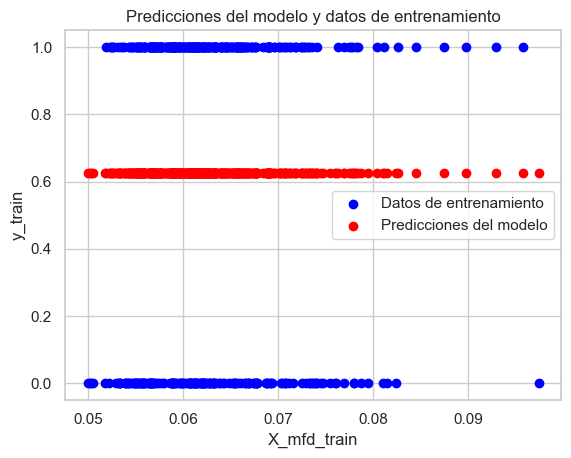

In [123]:
# Plot de los datos de entrenamiento
plt.scatter(X_mfd_train, y_train, color='blue', label='Datos de entrenamiento')

# Predicciones del modelo en los datos de entrenamiento
plt.scatter(X_mfd_train, modelo.predict_proba(X_mfd_train)[:, 1], color='red', label='Predicciones del modelo')

# Añadir etiquetas y leyenda
plt.xlabel('X_mfd_train')
plt.ylabel('y_train')
plt.title('Predicciones del modelo y datos de entrenamiento')
plt.legend()

# Mostrar el gráfico
plt.show()

In [124]:
coeficientes = modelo.coef_
intercepcion = modelo.intercept_

# Imprimir los coeficientes y el término de intercepción
print("Coeficientes:", coeficientes)
print("Intercept:", intercepcion)

Coeficientes: [[0.03224828]]
Intercept: [0.51466397]


WOE normales

In [125]:
X_mfd_woe_train = np.array(X_train_woe[variable + '_woe']).reshape(-1, 1)
X_mfd_woe_test = np.array(X_test_woe[variable + '_woe']).reshape(-1, 1)

In [126]:
# Crear el modelo de regresión logística
modelo = LogisticRegression(penalty=None)

# Ajustar el modelo con los datos de entrenamiento
modelo.fit(X_mfd_woe_train, y_train)

# Predecir en los datos de prueba
predicciones = modelo.predict(X_mfd_woe_test)

# Evaluar el modelo
accuracy = modelo.score(X_mfd_woe_test, y_test)
print("Exactitud del modelo:", accuracy)

# Predecir probabilidades en lugar de clases
predicciones_prob = modelo.predict_proba(X_mfd_woe_test)[:, 1]

# Calcular el AUC
auc = roc_auc_score(y_test, predicciones_prob)
print("Área bajo la curva ROC (AUC):", auc)

Exactitud del modelo: 0.6666666666666666
Área bajo la curva ROC (AUC): 0.6382275132275133


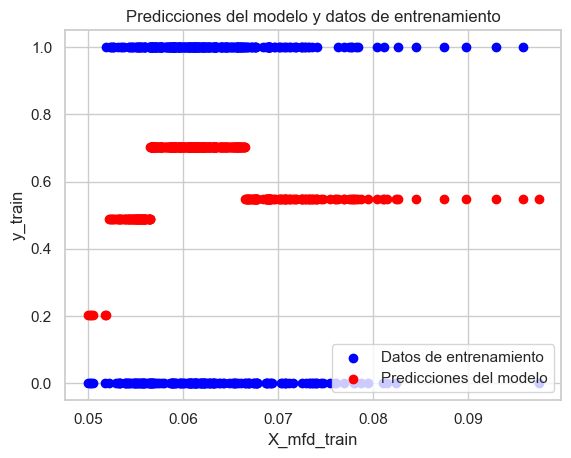

In [127]:
# Plot de los datos de entrenamiento
plt.scatter(X_mfd_train, y_train, color='blue', label='Datos de entrenamiento')

# Predicciones del modelo en los datos de entrenamiento
plt.scatter(X_mfd_train, modelo.predict_proba(X_mfd_woe_train)[:, 1], color='red', label='Predicciones del modelo')

# Añadir etiquetas y leyenda
plt.xlabel('X_mfd_train')
plt.ylabel('y_train')
plt.title('Predicciones del modelo y datos de entrenamiento')
plt.legend()

# Mostrar el gráfico
plt.show()

#Notar que este grafico (el rojo) coincide con el de plot_woe (la forma, las woe estan despues dibbujadas)

Fuzzy WOE FA

In [128]:
X_mfd_fuzzy_woe_fa_train = np.array(X_train_fuzzy_woe_fa[variable + '_fuzzy_woe_fa']).reshape(-1, 1)
X_mfd_fuzzy_woe_fa_test = np.array(X_test_fuzzy_woe_fa[variable + '_fuzzy_woe_fa']).reshape(-1, 1)

In [129]:
# Crear el modelo de regresión logística
modelo = LogisticRegression(penalty=None)

# Ajustar el modelo con los datos de entrenamiento
modelo.fit(X_mfd_fuzzy_woe_fa_train, y_train)

# Predecir en los datos de prueba
predicciones = modelo.predict(X_mfd_fuzzy_woe_fa_test)

# Evaluar el modelo
accuracy = modelo.score(X_mfd_fuzzy_woe_fa_test, y_test)
print("Exactitud del modelo:", accuracy)

# Predecir probabilidades en lugar de clases
predicciones_prob = modelo.predict_proba(X_mfd_fuzzy_woe_fa_test)[:, 1]

# Calcular el AUC
auc = roc_auc_score(y_test, predicciones_prob)
print("Área bajo la curva ROC (AUC):", auc)

Exactitud del modelo: 0.6666666666666666
Área bajo la curva ROC (AUC): 0.6456679894179895


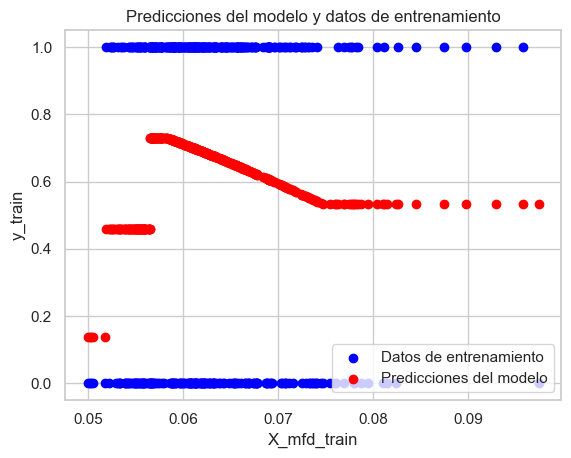

In [130]:
# Plot de los datos de entrenamiento
plt.scatter(X_mfd_train, y_train, color='blue', label='Datos de entrenamiento')

# Predicciones del modelo en los datos de entrenamiento
plt.scatter(X_mfd_train, modelo.predict_proba(X_mfd_fuzzy_woe_fa_train)[:, 1], color='red', label='Predicciones del modelo')

# Añadir etiquetas y leyenda
plt.xlabel('X_mfd_train')
plt.ylabel('y_train')
plt.title('Predicciones del modelo y datos de entrenamiento')
plt.legend()

# Mostrar el gráfico
plt.show()

Fuzzy woe

In [131]:
X_mfd_fuzzy_woe_train = np.array(X_train_fuzzy_woe[variable + '_fuzzy_woe']).reshape(-1, 1)
X_mfd_fuzzy_woe_test = np.array(X_test_fuzzy_woe[variable + '_fuzzy_woe']).reshape(-1, 1)

In [132]:
# Crear el modelo de regresión logística
modelo = LogisticRegression(penalty=None)

# Ajustar el modelo con los datos de entrenamiento
modelo.fit(X_mfd_fuzzy_woe_train, y_train)

# Predecir en los datos de prueba
predicciones = modelo.predict(X_mfd_fuzzy_woe_test)

# Evaluar el modelo
accuracy = modelo.score(X_mfd_fuzzy_woe_test, y_test)
print("Exactitud del modelo:", accuracy)

# Predecir probabilidades en lugar de clases
predicciones_prob = modelo.predict_proba(X_mfd_fuzzy_woe_test)[:, 1]

# Calcular el AUC
auc = roc_auc_score(y_test, predicciones_prob)
print("Área bajo la curva ROC (AUC):", auc)

Exactitud del modelo: 0.6666666666666666
Área bajo la curva ROC (AUC): 0.646660052910053


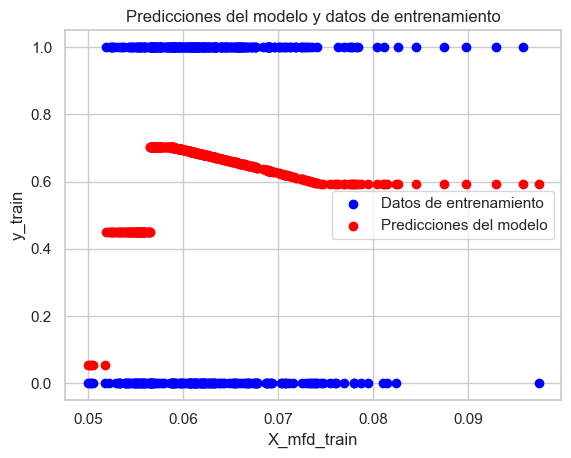

In [133]:
# Plot de los datos de entrenamiento
plt.scatter(X_mfd_train, y_train, color='blue', label='Datos de entrenamiento')

# Predicciones del modelo en los datos de entrenamiento
plt.scatter(X_mfd_train, modelo.predict_proba(X_mfd_fuzzy_woe_train)[:, 1], color='red', label='Predicciones del modelo')

# Añadir etiquetas y leyenda
plt.xlabel('X_mfd_train')
plt.ylabel('y_train')
plt.title('Predicciones del modelo y datos de entrenamiento')
plt.legend()

# Mostrar el gráfico
plt.show()

Esto son las predicciones, los valores de las woe son:

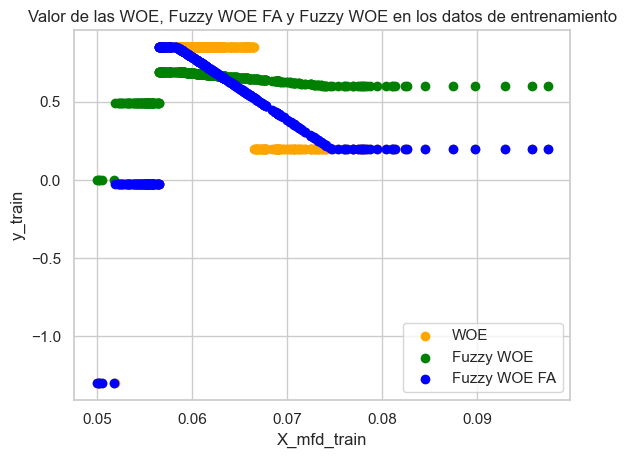

In [134]:
# Plot de los datos de entrenamiento
plt.scatter(X_mfd_train, X_mfd_woe_train, color='orange', label='WOE')
plt.scatter(X_mfd_train, X_mfd_fuzzy_woe_train, color='green', label='Fuzzy WOE')
plt.scatter(X_mfd_train, X_mfd_fuzzy_woe_fa_train, color='blue', label='Fuzzy WOE FA')

# Añadir etiquetas y leyenda
plt.xlabel('X_mfd_train')
plt.ylabel('y_train')
plt.title('Valor de las WOE, Fuzzy WOE FA y Fuzzy WOE en los datos de entrenamiento')
plt.legend()

# Mostrar el gráfico
plt.show()


XGBoost

In [135]:
# Crear el DMatrix de XGBoost
train_dmatrix = xgb.DMatrix(data=X_mfd_train, label=y_train)
test_dmatrix = xgb.DMatrix(data=X_mfd_test, label=y_test)

In [136]:
# Configurar los parámetros del modelo
params = {
    'objective': 'binary:logistic',  # para clasificación binaria
    'max_depth': 6,                  # profundidad máxima del árbol
    'eta': 0.3,                      # tasa de aprendizaje
    'seed': 42                       # semilla para reproducibilidad
}

In [137]:
# Entrenar el modelo
num_round = 100
bst = xgb.train(params, train_dmatrix, num_round)

In [138]:
from sklearn.metrics import accuracy_score

In [139]:
# Realizar predicciones
preds = bst.predict(test_dmatrix)

auc = roc_auc_score(y_test, preds)
print(f'AUC: {auc}')

AUC: 0.5591931216931216


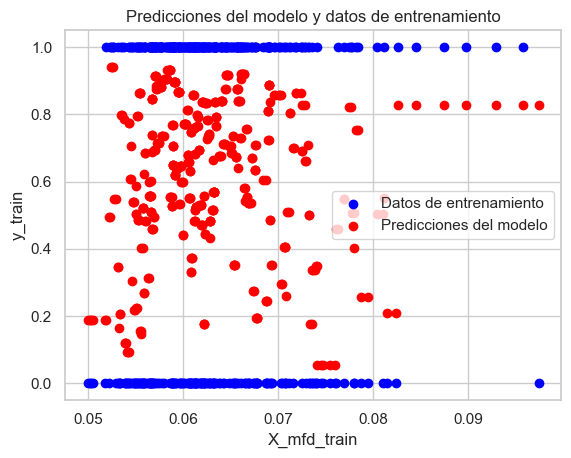

In [140]:
# Plot de los datos de entrenamiento
plt.scatter(X_mfd_train, y_train, color='blue', label='Datos de entrenamiento')

# Predicciones del modelo en los datos de entrenamiento
plt.scatter(X_mfd_train, bst.predict(train_dmatrix), color='red', label='Predicciones del modelo')

# Añadir etiquetas y leyenda
plt.xlabel('X_mfd_train')
plt.ylabel('y_train')
plt.title('Predicciones del modelo y datos de entrenamiento')
plt.legend()

# Mostrar el gráfico
plt.show()

Random Forest

In [141]:
from sklearn.ensemble import RandomForestClassifier

In [142]:
# Crear el modelo de Random Forest
modelo_rf = RandomForestClassifier()

# Ajustar el modelo con los datos de entrenamiento
modelo_rf.fit(X_mfd_train, y_train)

# Predecir en los datos de prueba
predicciones_rf = modelo_rf.predict(X_mfd_test)

# Evaluar el modelo
accuracy_rf = accuracy_score(y_test, predicciones_rf)
print("Exactitud del modelo Random Forest:", accuracy_rf)

# Predecir probabilidades en lugar de clases
predicciones_prob_rf = modelo_rf.predict_proba(X_mfd_test)[:, 1]

# Calcular el AUC
auc_rf = roc_auc_score(y_test, predicciones_prob_rf)
print("Área bajo la curva ROC (AUC) del modelo Random Forest:", auc_rf)

Exactitud del modelo Random Forest: 0.5789473684210527
Área bajo la curva ROC (AUC) del modelo Random Forest: 0.5608465608465608


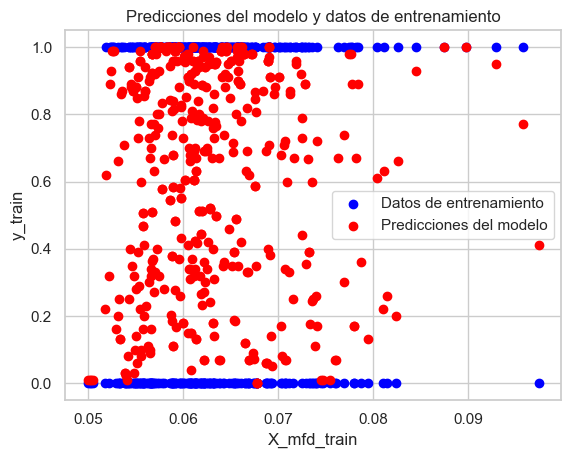

In [143]:
# Plot de los datos de entrenamiento
plt.scatter(X_mfd_train, y_train, color='blue', label='Datos de entrenamiento')

# Predicciones del modelo en los datos de entrenamiento
plt.scatter(X_mfd_train, modelo_rf.predict_proba(X_mfd_train)[:, 1], color='red', label='Predicciones del modelo')

# Añadir etiquetas y leyenda
plt.xlabel('X_mfd_train')
plt.ylabel('y_train')
plt.title('Predicciones del modelo y datos de entrenamiento')
plt.legend()

# Mostrar el gráfico
plt.show()